# Further Experimentation - Altering Dense Blocks and BC Models

## Contents:<a class="anchor" id="contents"></a>
* [Setup, Data preparation and Callbacks](#setup)
* [Experimenting with alternate number of dense blocks and depth](#altblocks)
* [Experimenting with bottleneck layers and compression](#bcmodels)

## Setup, Data preparation and Callbacks <a class="anchor" id="setup"></a>
----------------------------------

In [1]:
%load_ext jupyternotify
import time
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve
from keras import models, layers, optimizers, regularizers
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical
from keras import Input
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import keras
import os, shutil
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras_gcnn.layers import GConv2D, GBatchNorm
from keras_gcnn.layers.pooling import GroupPool

#Loading my custom functions from a separate Jupyter notebook
from ipynb.fs.full.my_functions import build_and_compile_model, build_and_compile_model_GCNN, fit_model_to_generator, plot_auc, area_under_ROC_curve
from ipynb.fs.full.my_functions import plot_results,plot_graphs, plot_smooth, plot_smooth_graphs, fit_model_to_directory_generator, evaluate_auc
from ipynb.fs.full.my_functions import build_and_compile_dense_model, crop, memory_required, count_conv_layers
from ipynb.fs.full.my_functions import model_ensemble_evaluation, acc_comparison, save_history, load_history

<IPython.core.display.Javascript object>

Using TensorFlow backend.


### Setting up custom Keras callbacks, mimicing the training setup of the academic papers.

In [2]:
class TimeSpent(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch_times = []
    def on_epoch_begin(self, epoch,logs={}):
        self.time_started = time.time()
    def on_epoch_end(self, epoch,logs={}):
        self.epoch_times.append(time.time()-self.time_started)
        
class LR_modifier(keras.callbacks.Callback):
    def __init__(self,
                 monitor='val_loss',
                 patience=0,
                 verbose=0):
        super(LR_modifier, self).__init__()

        self.monitor = monitor
        self.monitor_op = np.less
        self.patience = patience
        self.verbose = verbose
        self.wait = 0

    def on_train_begin(self, logs=None):
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = self.get_monitor_value(logs)
        if current is None:
            return

        if self.monitor_op(current, self.best):
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                curr_lr = float(K.get_value(self.model.optimizer.lr))
                new_lr = curr_lr/2.
                K.set_value(self.model.optimizer.lr, new_lr)
                self.wait=0
                if(self.verbose==1):
                    print("Learn rate updated from {} to: {}".format(curr_lr,new_lr))

    def get_monitor_value(self, logs):
        monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            warnings.warn(
                'Early stopping conditioned on metric `%s` '
                'which is not available. Available metrics are: %s' %
                (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
            )
        return monitor_value

    

time_check = TimeSpent()
lr_mod = LR_modifier(monitor="val_loss",patience=20,verbose=1)


totalepochs = 300
def sched(epoch,lr):
    if epoch == totalepochs*0.5 or epoch == totalepochs*0.75:
        return lr/10
    return lr

callbacks = [time_check,
            keras.callbacks.LearningRateScheduler(sched, verbose=1),
            keras.callbacks.ModelCheckpoint(
                filepath="../model_saves/PCAM/PCAM_Dense/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                monitor='val_loss',
                save_best_only=True),
#             keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=100)
            ]

#### Rotational paper callbacks

In [3]:
callbacks = [time_check,
            keras.callbacks.ModelCheckpoint(
                filepath="../model_saves/PCAM/PCAM_Dense/weights.{epoch:02d}-{val_loss:.2f}.hdf5",
                monitor='val_loss',
                save_best_only=True),
             lr_mod
            ]

#### Data preparation and generator setup

In [3]:
base_dir = "C:/GitRepos/FINAL PROJECT DATA/Histopathologic Cancer Detection/WholePCamSetFromGithub/converted_images/"
tr_dir = os.path.join(base_dir, "train")
va_dir = os.path.join(base_dir, "valid")
te_dir = os.path.join(base_dir, "test")

train_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64 
targ_size = (96,96)
classification = "binary"


validation_generator = train_datagen.flow_from_directory(
    va_dir,
    target_size=targ_size,
    batch_size=batch_size,
    class_mode=classification)

test_generator = train_datagen.flow_from_directory(
    te_dir,
    target_size=targ_size,
    batch_size=batch_size,
    class_mode=classification)

Found 32768 images belonging to 2 classes.
Found 32768 images belonging to 2 classes.


## Experimenting with alternate block numbers and depth<a class="anchor" id="altblocks"></a>
----------------------------------

#### Note - Some models referenced in the report were renamed to better reflect their properties rather than chronological training order. As such the names in this notebook are swapped around in some cases.

#### Model 1

In [6]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_DenseNet_DenseBlocks = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=3,conv_layers=2,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [22]:
P4M_Altblocks.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 94, 94, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 94, 94, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 94, 94, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [9]:
%%notify

totalepochs=300

historyP4M_Altblocks = fit_model_to_directory_generator(P4M_Altblocks,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_Altblocks = np.sum(time_check.epoch_times)
P4M_Altblocks.save_weights("model_saves/PCAM/P4M_AltblocksFinal.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 191s 613ms/step - loss: 0.4920 - acc: 0.7874 - val_loss: 0.9435 - val_acc: 0.6189
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 187s 599ms/step - loss: 0.4545 - acc: 0.8092 - val_loss: 0.5339 - val_acc: 0.7776
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 187s 599ms/step - loss: 0.4469 - acc: 0.8094 - val_loss: 1.3481 - val_acc: 0.5478
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 187s 599ms/step - loss: 0.4353 - acc: 0.8156 - val_loss: 0.5921 - val_acc: 0.7111
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 185s 594ms/step - loss: 0.3285 - acc: 0.8770 - val_loss: 0.8237 - val_acc: 0.7505
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 185s 593ms/step - loss: 0.3118 - acc: 0.8854 - val_loss: 1.6486 - val_acc: 0.5948
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 185s 594ms/step - loss: 0.3172 - acc: 0.8829 - val_loss: 1.9061 - val_acc: 0.7007
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 185s 594ms/step - loss: 0.3124 - acc: 0.8839 - val_loss: 0.6913 - val_acc: 0.7379
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 185s 594ms/step - loss: 0.3119 - acc: 0.8840 - val_loss: 1.3709 - val_acc: 0.

312/312 [==============================] - 185s 593ms/step - loss: 0.2476 - acc: 0.9202 - val_loss: 0.5879 - val_acc: 0.8164
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 185s 594ms/step - loss: 0.2549 - acc: 0.9170 - val_loss: 0.9575 - val_acc: 0.7403
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 185s 594ms/step - loss: 0.2514 - acc: 0.9193 - val_loss: 0.7792 - val_acc: 0.7023
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 185s 594ms/step - loss: 0.2433 - acc: 0.9222 - val_loss: 0.5390 - val_acc: 0.7881
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 185s 594ms/step - loss: 0.2470 - acc: 0.9220 - val_loss: 1.2295 - val_acc

312/312 [==============================] - 189s 606ms/step - loss: 0.1657 - acc: 0.9524 - val_loss: 0.8232 - val_acc: 0.7990
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 191s 614ms/step - loss: 0.1668 - acc: 0.9518 - val_loss: 0.5972 - val_acc: 0.8233
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 191s 614ms/step - loss: 0.1690 - acc: 0.9490 - val_loss: 0.4780 - val_acc: 0.8299
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 191s 613ms/step - loss: 0.1676 - acc: 0.9516 - val_loss: 0.4788 - val_acc: 0.8629
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 192s 614ms/step - loss: 0.1647 - acc: 0.9519 - val_loss: 0.7819 - val

312/312 [==============================] - 192s 615ms/step - loss: 0.1656 - acc: 0.9497 - val_loss: 0.5284 - val_acc: 0.8343
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 189s 607ms/step - loss: 0.1632 - acc: 0.9492 - val_loss: 0.4454 - val_acc: 0.8543
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 189s 606ms/step - loss: 0.1577 - acc: 0.9523 - val_loss: 0.4506 - val_acc: 0.8484
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 190s 608ms/step - loss: 0.1563 - acc: 0.9533 - val_loss: 0.4598 - val_acc: 0.8529
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 188s 601ms/step - loss: 0.1476 - acc: 0.9576 - val_loss: 0.4346 - v

312/312 [==============================] - 190s 610ms/step - loss: 0.1452 - acc: 0.9579 - val_loss: 0.4212 - val_acc: 0.8668
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 191s 611ms/step - loss: 0.1457 - acc: 0.9575 - val_loss: 0.4893 - val_acc: 0.8462
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 191s 611ms/step - loss: 0.1385 - acc: 0.9595 - val_loss: 0.4117 - val_acc: 0.8666
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 190s 610ms/step - loss: 0.1355 - acc: 0.9605 - val_loss: 0.4366 - val_acc: 0.8648
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 191s 611ms/step - loss: 0.1370 - acc: 0.9595 - val_loss: 0.4594 -

312/312 [==============================] - 188s 603ms/step - loss: 0.1365 - acc: 0.9592 - val_loss: 0.4221 - val_acc: 0.8690
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 189s 605ms/step - loss: 0.1404 - acc: 0.9578 - val_loss: 0.4877 - val_acc: 0.8603
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 191s 611ms/step - loss: 0.1381 - acc: 0.9594 - val_loss: 0.4663 - val_acc: 0.8514
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 189s 605ms/step - loss: 0.1412 - acc: 0.9597 - val_loss: 0.5220 - val_acc: 0.8462


NameError: name 'save_history' is not defined

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

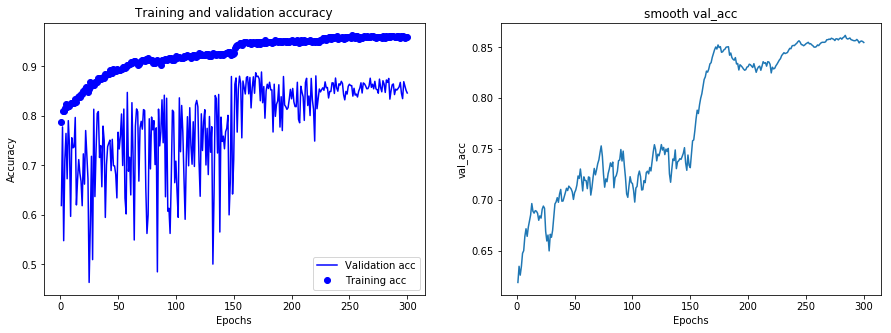

Highest val accuracy: x= 173, y= 0.8886374755381604


<Figure size 432x288 with 0 Axes>

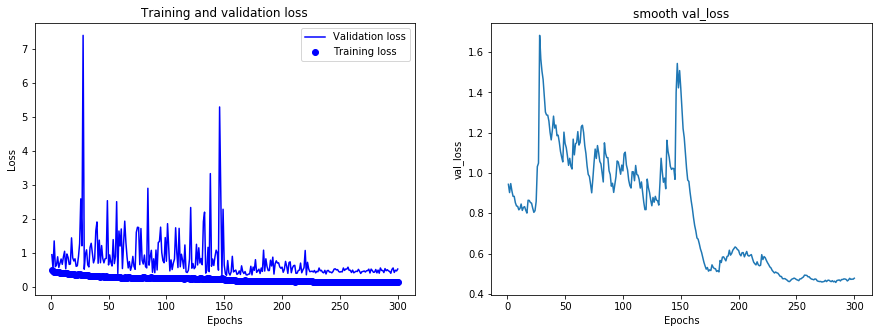

Lowest val loss: x= 147, y= 0.33196611232953527
56109.47097015381


In [11]:
plot_graphs(historyP4M_Altblocks)
print(timeP4M_Altblocks)

In [16]:
P4M_Altblocks.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_AltblocksFinal.h5")

In [17]:
P4M_Altblocks.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.44980895035187557, 0.861943493150685]

<Figure size 432x288 with 0 Axes>

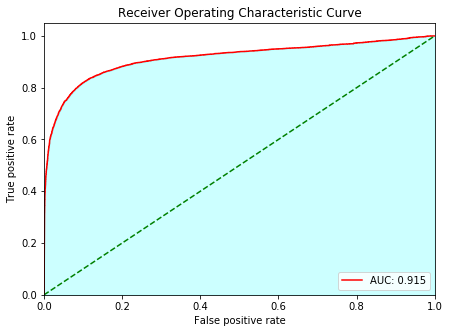

In [18]:
evaluate_auc(P4M_Altblocks,test_generator)

In [19]:
P4M_Altblocks.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_AltblocksBestWeights143epochs.hdf5")

In [20]:
P4M_Altblocks.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.5413794763050901, 0.823752446183953]

<Figure size 432x288 with 0 Axes>

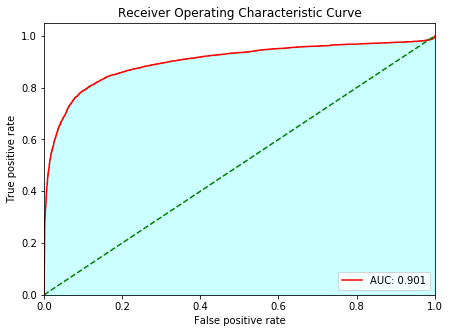

In [21]:
evaluate_auc(P4M_Altblocks,test_generator)

#### Model 2

In [6]:
initial_filters = 4
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_Altblocks2 = build_and_compile_dense_model(initial_filters,growth_rate=4,dense_blocks=3,conv_layers=3,
                                           is_gconv=True,gconv_type="D4",padding="valid",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [6]:
P4M_Altblocks2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 94, 94, 32)   108         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 94, 94, 32)   32          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 94, 94, 32)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [7]:
memory_required(P4M_Altblocks2,64)

4.244

In [7]:
%%notify

totalepochs=160

historyP4M_Altblocks2 = fit_model_to_directory_generator(P4M_Altblocks2,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_Altblocks2 = np.sum(time_check.epoch_times)
P4M_Altblocks2.save_weights("../model_saves/PCAM/PCam_Dense/P4M_Altblocks2Final.h5")
#save_history(historyP4M_DenseNet_DenseBlocks,"historyP4M_DenseNet_DenseBlocks")

Found 262144 images belonging to 2 classes.
Epoch 1/160

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 118s 378ms/step - loss: 0.4890 - acc: 0.7839 - val_loss: 1.3332 - val_acc: 0.6685
Epoch 2/160

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 112s 360ms/step - loss: 0.4656 - acc: 0.7955 - val_loss: 0.8892 - val_acc: 0.7458
Epoch 3/160

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 113s 361ms/step - loss: 0.4497 - acc: 0.8052 - val_loss: 1.4995 - val_acc: 0.6241
Epoch 4/160

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 113s 361ms/step - loss: 0.4505 - acc: 0.8057 - val_loss: 0.9973 - val_acc: 0.7429
Epoch 5/160

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 113s 362ms/step - loss: 0.2905 - acc: 0.8949 - val_loss: 0.6492 - val_acc: 0.7575
Epoch 39/160

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 113s 362ms/step - loss: 0.2931 - acc: 0.8928 - val_loss: 0.9650 - val_acc: 0.6024
Epoch 40/160

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 114s 365ms/step - loss: 0.2944 - acc: 0.8928 - val_loss: 0.7164 - val_acc: 0.6660
Epoch 41/160

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 114s 365ms/step - loss: 0.2859 - acc: 0.8952 - val_loss: 0.5020 - val_acc: 0.7929
Epoch 42/160

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 114s 366ms/step - loss: 0.2833 - acc: 0.9000 - val_loss: 0.7076 - val_acc: 0.

312/312 [==============================] - 114s 364ms/step - loss: 0.2150 - acc: 0.9295 - val_loss: 0.6744 - val_acc: 0.7533
Epoch 113/160

Epoch 00113: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 114s 364ms/step - loss: 0.2151 - acc: 0.9280 - val_loss: 0.4880 - val_acc: 0.8186
Epoch 114/160

Epoch 00114: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 114s 364ms/step - loss: 0.2157 - acc: 0.9279 - val_loss: 0.6909 - val_acc: 0.7955
Epoch 115/160

Epoch 00115: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 113s 362ms/step - loss: 0.2115 - acc: 0.9293 - val_loss: 0.6960 - val_acc: 0.7719
Epoch 116/160

Epoch 00116: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 113s 362ms/step - loss: 0.2170 - acc: 0.9255 - val_loss: 0.6716 - val

312/312 [==============================] - 113s 362ms/step - loss: 0.2044 - acc: 0.9336 - val_loss: 0.7870 - val_acc: 0.7607
Epoch 150/160

Epoch 00150: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 113s 362ms/step - loss: 0.1959 - acc: 0.9359 - val_loss: 0.7740 - val_acc: 0.7710
Epoch 151/160

Epoch 00151: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 113s 362ms/step - loss: 0.2059 - acc: 0.9338 - val_loss: 0.7164 - val_acc: 0.7749
Epoch 152/160

Epoch 00152: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 113s 362ms/step - loss: 0.1957 - acc: 0.9363 - val_loss: 0.7663 - val_acc: 0.7623
Epoch 153/160

Epoch 00153: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 113s 363ms/step - loss: 0.1952 - acc: 0.9371 - val_loss: 0.6657 -

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

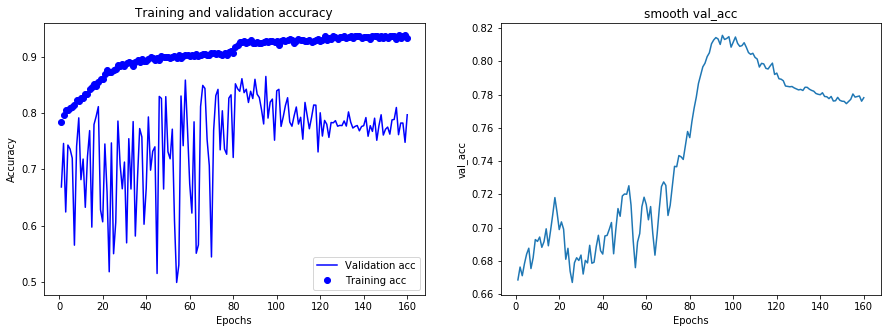

Highest val accuracy: x= 94, y= 0.8647566046966731


<Figure size 432x288 with 0 Axes>

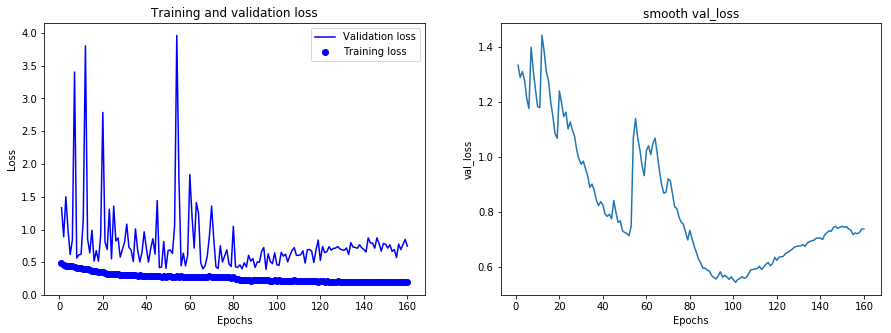

Lowest val loss: x= 94, y= 0.39006007519603475
18105.07257914543


In [8]:
plot_graphs(historyP4M_Altblocks2)
print(timeP4M_Altblocks2)

In [9]:
P4M_Altblocks2.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.7016143204822932, 0.7948568982387475]

<Figure size 432x288 with 0 Axes>

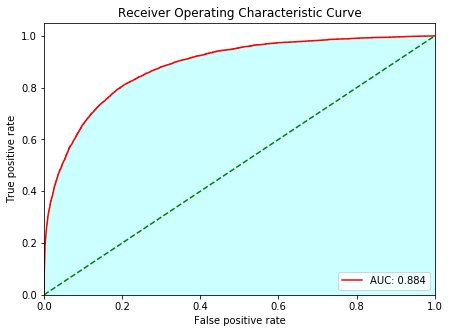

In [10]:
evaluate_auc(P4M_Altblocks2,test_generator)

In [11]:
P4M_Altblocks2.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_Altblocks2BestWeights95epochs.hdf5")

In [12]:
P4M_Altblocks2.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.39910013457567023, 0.8621575342465754]

<Figure size 432x288 with 0 Axes>

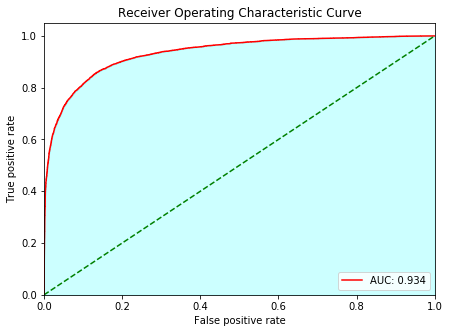

In [13]:
evaluate_auc(P4M_Altblocks2,test_generator)

#### Model 3 - changing padding and making deeper

#### Batchsize made this super noisy, though I expect it wouldn't have been great anyway.

In [15]:
initial_filters = 4
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_Altblocks3 = build_and_compile_dense_model(initial_filters,growth_rate=4,dense_blocks=3,conv_layers=6,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [18]:
P4M_Altblocks3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 96, 96, 32)   108         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 96, 96, 32)   32          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 32)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [17]:
memory_required(P4M_Altblocks3,24)

4.845

In [6]:
%%notify

totalepochs=160

historyP4M_Altblocks3 = fit_model_to_directory_generator(P4M_Altblocks3,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=24,epochs=totalepochs,verbose=1)
timeP4M_Altblocks3 = np.sum(time_check.epoch_times)
P4M_Altblocks3.save_weights("../model_saves/PCAM/PCam_Dense/P4M_Altblocks3Final.h5")
#save_history(historyP4M_DenseNet_DenseBlocks,"historyP4M_DenseNet_DenseBlocks")

Found 262144 images belonging to 2 classes.
Epoch 1/160

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 234s 750ms/step - loss: 0.5075 - acc: 0.7842 - val_loss: 0.5967 - val_acc: 0.7747
Epoch 2/160

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 226s 723ms/step - loss: 0.4651 - acc: 0.8085 - val_loss: 0.9196 - val_acc: 0.5226
Epoch 3/160

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 226s 723ms/step - loss: 0.4619 - acc: 0.8078 - val_loss: 0.8092 - val_acc: 0.5764
Epoch 4/160

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 226s 724ms/step - loss: 0.4622 - acc: 0.8018 - val_loss: 3.8662 - val_acc: 0.6229
Epoch 5/160

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 218s 699ms/step - loss: 0.3532 - acc: 0.8662 - val_loss: 0.5186 - val_acc: 0.7792
Epoch 39/160

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 218s 699ms/step - loss: 0.3469 - acc: 0.8691 - val_loss: 0.4260 - val_acc: 0.8409
Epoch 40/160

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 218s 699ms/step - loss: 0.3509 - acc: 0.8714 - val_loss: 0.4860 - val_acc: 0.7883
Epoch 41/160

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 218s 699ms/step - loss: 0.3449 - acc: 0.8717 - val_loss: 0.4991 - val_acc: 0.8134
Epoch 42/160

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 218s 699ms/step - loss: 0.3498 - acc: 0.8678 - val_loss: 0.7878 - val_acc: 0.

312/312 [==============================] - 218s 699ms/step - loss: 0.2255 - acc: 0.9268 - val_loss: 1.0568 - val_acc: 0.7894
Epoch 113/160

Epoch 00113: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 218s 699ms/step - loss: 0.2354 - acc: 0.9259 - val_loss: 0.8286 - val_acc: 0.7716
Epoch 114/160

Epoch 00114: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 218s 699ms/step - loss: 0.2228 - acc: 0.9284 - val_loss: 1.3515 - val_acc: 0.7222
Epoch 115/160

Epoch 00115: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 218s 699ms/step - loss: 0.2312 - acc: 0.9240 - val_loss: 0.9693 - val_acc: 0.7533
Epoch 116/160

Epoch 00116: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 218s 699ms/step - loss: 0.2309 - acc: 0.9263 - val_loss: 0.9141 - val

312/312 [==============================] - 218s 699ms/step - loss: 0.2061 - acc: 0.9366 - val_loss: 1.0720 - val_acc: 0.7737
Epoch 150/160

Epoch 00150: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 218s 699ms/step - loss: 0.2082 - acc: 0.9294 - val_loss: 1.4683 - val_acc: 0.7298
Epoch 151/160

Epoch 00151: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 218s 699ms/step - loss: 0.2030 - acc: 0.9347 - val_loss: 1.4869 - val_acc: 0.7187
Epoch 152/160

Epoch 00152: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 218s 699ms/step - loss: 0.2083 - acc: 0.9331 - val_loss: 1.1876 - val_acc: 0.7557
Epoch 153/160

Epoch 00153: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 218s 699ms/step - loss: 0.2100 - acc: 0.9342 - val_loss: 1.3970 -

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

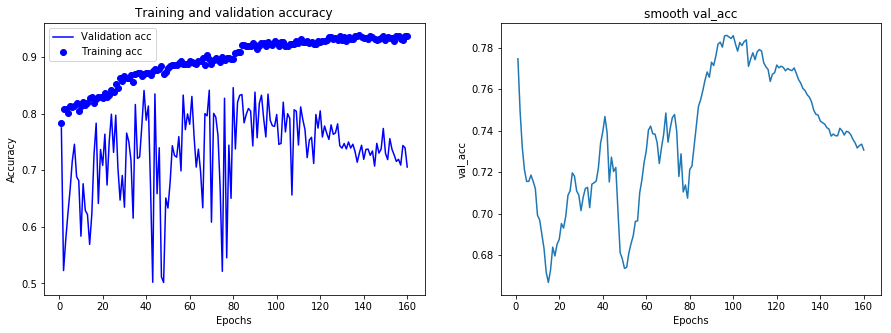

Highest val accuracy: x= 79, y= 0.8459209882583171


<Figure size 432x288 with 0 Axes>

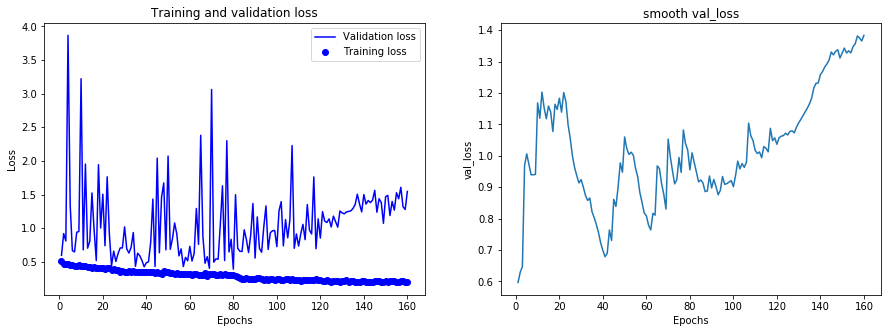

Lowest val loss: x= 79, y= 0.38984002794071654
35024.575189352036


In [11]:
plot_graphs(historyP4M_Altblocks3)
print(timeP4M_Altblocks3)

In [7]:
P4M_Altblocks3.evaluate_generator(test_generator,steps=len(test_generator)-1)

[1.4749407439315856, 0.7059075342465754]

<Figure size 432x288 with 0 Axes>

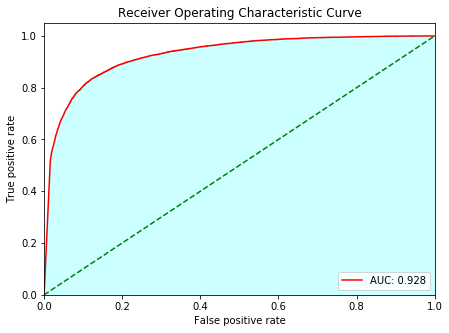

In [8]:
evaluate_auc(P4M_Altblocks3,test_generator)

In [13]:
P4M_Altblocks3.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_Altblocks3BestWeights80epochs.hdf5")

In [14]:
P4M_Altblocks3.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.35571966178846454, 0.8621269569471625]

<Figure size 432x288 with 0 Axes>

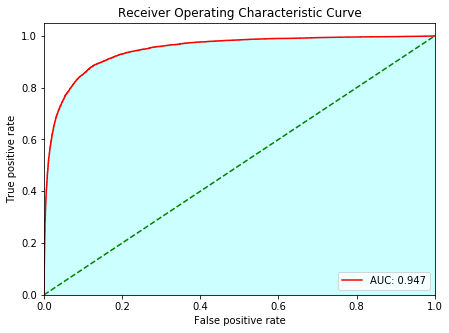

In [15]:
evaluate_auc(P4M_Altblocks3,test_generator)

##### Model 4 - Gonna try a more than 5 blocks model perhaps? same as p4m, alt train and "same" padding so I can try increase it.

In [4]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_Altblocks4 = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=6,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [5]:
P4M_Altblocks4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 96, 96, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 96, 96, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [6]:
%%notify

totalepochs=300

historyP4M_Altblocks4 = fit_model_to_directory_generator(P4M_Altblocks4,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_Altblocks4 = np.sum(time_check.epoch_times)
P4M_Altblocks4.save_weights("../model_saves/PCAM/PCam_Dense/P4M_Altblocks4Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 118s 378ms/step - loss: 0.4818 - acc: 0.8118 - val_loss: 0.7478 - val_acc: 0.6460
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 106s 339ms/step - loss: 0.4420 - acc: 0.8272 - val_loss: 1.5053 - val_acc: 0.4998
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.4219 - acc: 0.8363 - val_loss: 0.5329 - val_acc: 0.7672
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.4100 - acc: 0.8418 - val_loss: 0.5220 - val_acc: 0.7985
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 107s 343ms/step - loss: 0.2631 - acc: 0.9101 - val_loss: 0.5834 - val_acc: 0.7459
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 344ms/step - loss: 0.2576 - acc: 0.9126 - val_loss: 0.4045 - val_acc: 0.8427
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 344ms/step - loss: 0.2616 - acc: 0.9129 - val_loss: 0.5010 - val_acc: 0.8173
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 343ms/step - loss: 0.2574 - acc: 0.9131 - val_loss: 0.6693 - val_acc: 0.7467
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 344ms/step - loss: 0.2551 - acc: 0.9136 - val_loss: 0.4805 - val_acc: 0.

312/312 [==============================] - 104s 333ms/step - loss: 0.2089 - acc: 0.9374 - val_loss: 0.7491 - val_acc: 0.7254
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 104s 333ms/step - loss: 0.2068 - acc: 0.9394 - val_loss: 0.9542 - val_acc: 0.6734
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 104s 333ms/step - loss: 0.2095 - acc: 0.9373 - val_loss: 0.6668 - val_acc: 0.7871
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 104s 333ms/step - loss: 0.2096 - acc: 0.9367 - val_loss: 0.4812 - val_acc: 0.8105
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 104s 333ms/step - loss: 0.2061 - acc: 0.9397 - val_loss: 1.2830 - val_acc

312/312 [==============================] - 104s 332ms/step - loss: 0.1386 - acc: 0.9622 - val_loss: 0.2995 - val_acc: 0.8963
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 104s 333ms/step - loss: 0.1386 - acc: 0.9618 - val_loss: 0.2964 - val_acc: 0.8949
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 104s 332ms/step - loss: 0.1365 - acc: 0.9633 - val_loss: 0.2949 - val_acc: 0.9108
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 104s 332ms/step - loss: 0.1385 - acc: 0.9619 - val_loss: 0.5345 - val_acc: 0.8247
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 104s 333ms/step - loss: 0.1340 - acc: 0.9649 - val_loss: 0.2662 - val

312/312 [==============================] - 104s 332ms/step - loss: 0.1246 - acc: 0.9657 - val_loss: 1.1204 - val_acc: 0.7695
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 104s 332ms/step - loss: 0.1284 - acc: 0.9639 - val_loss: 0.5669 - val_acc: 0.8470
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 104s 332ms/step - loss: 0.1310 - acc: 0.9619 - val_loss: 1.2376 - val_acc: 0.7447
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 104s 332ms/step - loss: 0.1184 - acc: 0.9675 - val_loss: 0.2731 - val_acc: 0.9136
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 104s 332ms/step - loss: 0.1198 - acc: 0.9648 - val_loss: 0.2516 - v

312/312 [==============================] - 104s 332ms/step - loss: 0.1144 - acc: 0.9675 - val_loss: 0.4171 - val_acc: 0.8770
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 104s 332ms/step - loss: 0.1080 - acc: 0.9705 - val_loss: 0.2592 - val_acc: 0.9165
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 104s 332ms/step - loss: 0.1050 - acc: 0.9730 - val_loss: 0.2847 - val_acc: 0.9060
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 104s 332ms/step - loss: 0.1093 - acc: 0.9697 - val_loss: 0.3082 - val_acc: 0.9031
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 104s 333ms/step - loss: 0.1080 - acc: 0.9704 - val_loss: 0.2875 -

312/312 [==============================] - 104s 332ms/step - loss: 0.1045 - acc: 0.9715 - val_loss: 0.3067 - val_acc: 0.9029
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 104s 332ms/step - loss: 0.1071 - acc: 0.9705 - val_loss: 0.3062 - val_acc: 0.9036
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 104s 332ms/step - loss: 0.1108 - acc: 0.9694 - val_loss: 0.3432 - val_acc: 0.8925
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 104s 332ms/step - loss: 0.1125 - acc: 0.9691 - val_loss: 0.2741 - val_acc: 0.9092


<IPython.core.display.Javascript object>

In [20]:
save_history(historyP4M_Altblocks4,"historyP4M_Altblocks4")

<Figure size 432x288 with 0 Axes>

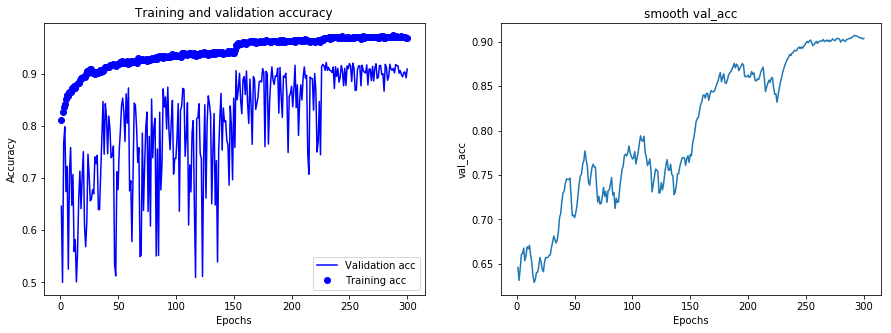

Highest val accuracy: x= 229, y= 0.9220584637964775


<Figure size 432x288 with 0 Axes>

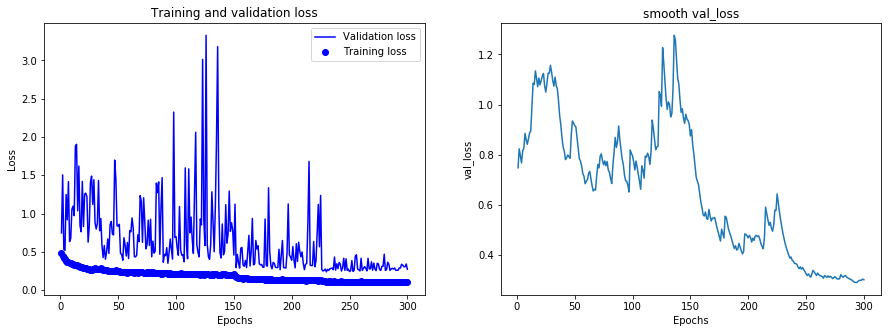

Lowest val loss: x= 229, y= 0.23992172896920352
31330.023452281952


In [8]:
plot_graphs(historyP4M_Altblocks4)
print(timeP4M_Altblocks4)

In [9]:
P4M_Altblocks4.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.2874194545900985, 0.9002874266144814]

<Figure size 432x288 with 0 Axes>

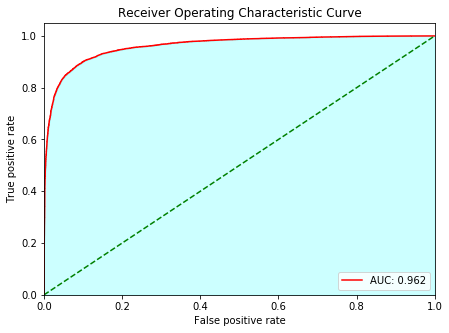

In [10]:
evaluate_auc(P4M_Altblocks4,test_generator)

In [33]:
P4M_Altblocks4.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_Altblocks4BestWeights229epochs.hdf5")

In [34]:
P4M_Altblocks4.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.28698762415848134, 0.9040790117416829]

<Figure size 432x288 with 0 Axes>

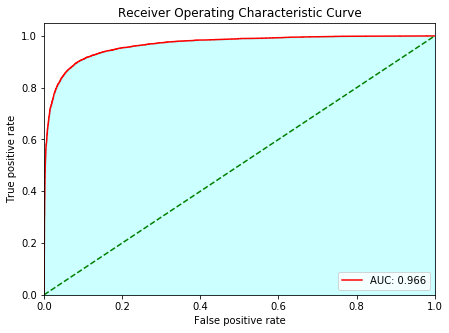

In [35]:
evaluate_auc(P4M_Altblocks4,test_generator)

##### Model 5 - 7 blocks instead of 6

In [4]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_Altblocks5 = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=7,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [5]:
P4M_Altblocks5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 96, 96, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 96, 96, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [6]:
memory_required(P4M_Altblocks5,64)

3.536

In [7]:
%%notify

totalepochs=300

historyP4M_Altblocks5 = fit_model_to_directory_generator(P4M_Altblocks5,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_Altblocks5 = np.sum(time_check.epoch_times)
P4M_Altblocks5.save_weights("../model_saves/PCAM/PCam_Dense/P4M_Altblocks5Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 110s 353ms/step - loss: 0.5103 - acc: 0.8016 - val_loss: 6.0545 - val_acc: 0.4993
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 106s 338ms/step - loss: 0.4481 - acc: 0.8298 - val_loss: 0.6292 - val_acc: 0.7082
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 342ms/step - loss: 0.4261 - acc: 0.8393 - val_loss: 0.9999 - val_acc: 0.6214
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 342ms/step - loss: 0.3987 - acc: 0.8502 - val_loss: 0.7920 - val_acc: 0.6306
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 107s 342ms/step - loss: 0.2402 - acc: 0.9233 - val_loss: 0.4502 - val_acc: 0.8452
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 342ms/step - loss: 0.2339 - acc: 0.9266 - val_loss: 0.3762 - val_acc: 0.8475
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 106s 341ms/step - loss: 0.2378 - acc: 0.9251 - val_loss: 0.7915 - val_acc: 0.7268
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 342ms/step - loss: 0.2388 - acc: 0.9231 - val_loss: 0.3492 - val_acc: 0.8712
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 106s 341ms/step - loss: 0.2275 - acc: 0.9292 - val_loss: 0.4463 - val_acc: 0.

312/312 [==============================] - 106s 341ms/step - loss: 0.2105 - acc: 0.9366 - val_loss: 0.5177 - val_acc: 0.8533
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 106s 339ms/step - loss: 0.2117 - acc: 0.9371 - val_loss: 1.4119 - val_acc: 0.5730
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 338ms/step - loss: 0.2057 - acc: 0.9394 - val_loss: 0.5708 - val_acc: 0.7861
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 106s 340ms/step - loss: 0.2125 - acc: 0.9363 - val_loss: 0.9598 - val_acc: 0.7701
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 342ms/step - loss: 0.2104 - acc: 0.9366 - val_loss: 1.6144 - val_acc

312/312 [==============================] - 107s 344ms/step - loss: 0.1355 - acc: 0.9630 - val_loss: 0.4146 - val_acc: 0.8675
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 106s 341ms/step - loss: 0.1352 - acc: 0.9639 - val_loss: 0.3298 - val_acc: 0.8932
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 107s 344ms/step - loss: 0.1368 - acc: 0.9647 - val_loss: 1.1434 - val_acc: 0.7624
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 108s 345ms/step - loss: 0.1382 - acc: 0.9629 - val_loss: 0.3694 - val_acc: 0.8811
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 107s 342ms/step - loss: 0.1340 - acc: 0.9634 - val_loss: 0.4553 - val

312/312 [==============================] - 107s 343ms/step - loss: 0.1281 - acc: 0.9621 - val_loss: 0.9828 - val_acc: 0.7788
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 107s 342ms/step - loss: 0.1262 - acc: 0.9644 - val_loss: 0.5634 - val_acc: 0.8197
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 107s 342ms/step - loss: 0.1315 - acc: 0.9619 - val_loss: 0.3323 - val_acc: 0.8852
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 107s 342ms/step - loss: 0.1175 - acc: 0.9677 - val_loss: 0.4752 - val_acc: 0.8648
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 106s 341ms/step - loss: 0.1163 - acc: 0.9684 - val_loss: 0.4027 - v

312/312 [==============================] - 108s 346ms/step - loss: 0.1089 - acc: 0.9712 - val_loss: 0.8575 - val_acc: 0.8010
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 108s 347ms/step - loss: 0.1121 - acc: 0.9692 - val_loss: 0.3773 - val_acc: 0.8864
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 108s 347ms/step - loss: 0.1024 - acc: 0.9737 - val_loss: 0.6058 - val_acc: 0.8426
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 109s 348ms/step - loss: 0.1105 - acc: 0.9692 - val_loss: 0.6081 - val_acc: 0.8502
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 109s 348ms/step - loss: 0.1065 - acc: 0.9720 - val_loss: 0.6886 -

312/312 [==============================] - 105s 337ms/step - loss: 0.1053 - acc: 0.9726 - val_loss: 1.1499 - val_acc: 0.7664
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1047 - acc: 0.9715 - val_loss: 0.4628 - val_acc: 0.8641
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1058 - acc: 0.9708 - val_loss: 0.5566 - val_acc: 0.8477
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1073 - acc: 0.9711 - val_loss: 0.6498 - val_acc: 0.8359


NameError: name 'history_Altblocks4' is not defined

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

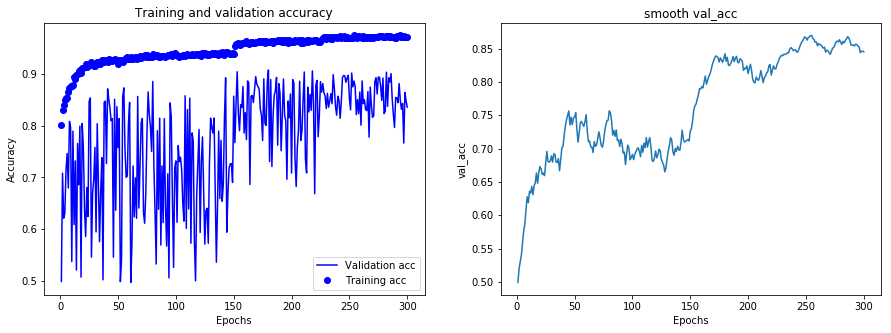

Highest val accuracy: x= 179, y= 0.9075648238747553


<Figure size 432x288 with 0 Axes>

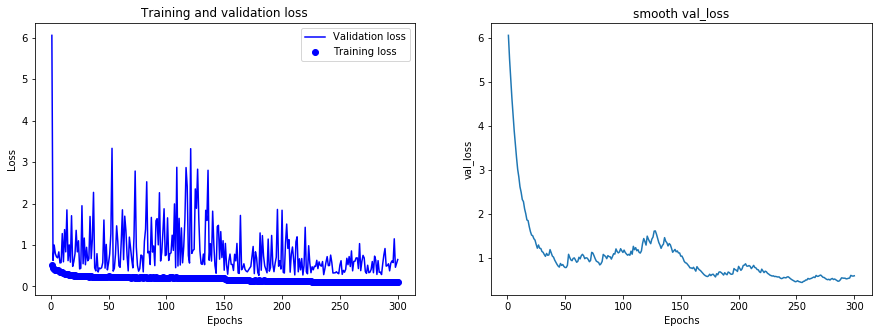

Lowest val loss: x= 179, y= 0.26772329591783295


In [11]:
plot_graphs(historyP4M_Altblocks5)

In [12]:
P4M_Altblocks5.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.6078420421673594, 0.8254953522504892]

<Figure size 432x288 with 0 Axes>

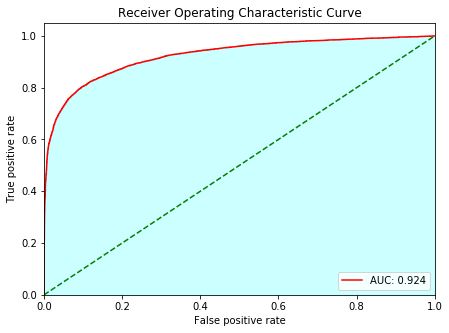

In [13]:
evaluate_auc(P4M_Altblocks5,test_generator)

In [28]:
P4M_Altblocks5.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_Altblocks5BestWeights180epochs.hdf5")

In [29]:
P4M_Altblocks5.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.4795071416755012, 0.8430772994129159]

<Figure size 432x288 with 0 Axes>

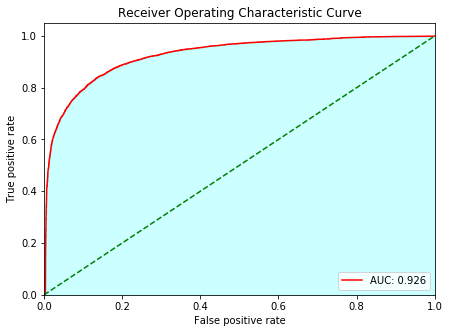

In [30]:
evaluate_auc(P4M_Altblocks5,test_generator)

#### Swapped model names in report of the below

#### Model - Reducing the number of blocks - first trying 3/1

In [4]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_Altblocks6 = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=3,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [5]:
P4M_Altblocks6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 96, 96, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 96, 96, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [6]:
memory_required(P4M_Altblocks6,64)

3.387

In [7]:
%%notify

totalepochs=300

historyP4M_Altblocks6 = fit_model_to_directory_generator(P4M_Altblocks6,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_Altblocks6 = np.sum(time_check.epoch_times)
P4M_Altblocks6.save_weights("../model_saves/PCAM/PCam_Dense/P4M_Altblocks6Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 104s 334ms/step - loss: 0.4643 - acc: 0.7960 - val_loss: 1.0290 - val_acc: 0.5531
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 101s 323ms/step - loss: 0.4308 - acc: 0.8160 - val_loss: 1.3909 - val_acc: 0.4525
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 100s 321ms/step - loss: 0.4127 - acc: 0.8252 - val_loss: 0.5460 - val_acc: 0.7773
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 101s 323ms/step - loss: 0.4078 - acc: 0.8295 - val_loss: 1.2294 - val_acc: 0.7008
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 98s 314ms/step - loss: 0.2850 - acc: 0.9025 - val_loss: 3.0648 - val_acc: 0.5012
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.3051 - acc: 0.8923 - val_loss: 0.4944 - val_acc: 0.7703
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2852 - acc: 0.9027 - val_loss: 1.8072 - val_acc: 0.5077
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2881 - acc: 0.9027 - val_loss: 1.2442 - val_acc: 0.5103
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2863 - acc: 0.9005 - val_loss: 0.4287 - val_acc: 0.8207


Epoch 76/300

Epoch 00076: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2434 - acc: 0.9222 - val_loss: 0.6123 - val_acc: 0.7173
Epoch 77/300

Epoch 00077: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2559 - acc: 0.9160 - val_loss: 0.4924 - val_acc: 0.8442
Epoch 78/300

Epoch 00078: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2522 - acc: 0.9176 - val_loss: 0.8459 - val_acc: 0.7129
Epoch 79/300

Epoch 00079: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2383 - acc: 0.9234 - val_loss: 0.4693 - val_acc: 0.8194
Epoch 80/300

Epoch 00080: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [====================

312/312 [==============================] - 98s 314ms/step - loss: 0.2360 - acc: 0.9239 - val_loss: 1.1819 - val_acc: 0.7154
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2444 - acc: 0.9214 - val_loss: 2.2153 - val_acc: 0.5291
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2385 - acc: 0.9227 - val_loss: 0.4507 - val_acc: 0.8344
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2333 - acc: 0.9228 - val_loss: 1.3162 - val_acc: 0.6648
Epoch 117/300

Epoch 00117: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 98s 314ms/step - loss: 0.2395 - acc: 0.9222 - val_loss: 2.6159 - val_acc: 0.6

312/312 [==============================] - 98s 314ms/step - loss: 0.1747 - acc: 0.9489 - val_loss: 0.3850 - val_acc: 0.8518
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 98s 314ms/step - loss: 0.1595 - acc: 0.9532 - val_loss: 0.9283 - val_acc: 0.7172
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 98s 314ms/step - loss: 0.1642 - acc: 0.9502 - val_loss: 1.2299 - val_acc: 0.6832
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 98s 314ms/step - loss: 0.1675 - acc: 0.9485 - val_loss: 0.3869 - val_acc: 0.8368
Epoch 191/300

Epoch 00191: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 98s 314ms/step - loss: 0.1685 - acc: 0.9501 - val_loss: 0.3456 - val_acc:

312/312 [==============================] - 98s 314ms/step - loss: 0.1460 - acc: 0.9557 - val_loss: 0.4413 - val_acc: 0.8322
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 98s 314ms/step - loss: 0.1471 - acc: 0.9535 - val_loss: 0.3095 - val_acc: 0.8879
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 98s 314ms/step - loss: 0.1411 - acc: 0.9560 - val_loss: 0.3873 - val_acc: 0.8499
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 98s 314ms/step - loss: 0.1384 - acc: 0.9573 - val_loss: 0.3122 - val_acc: 0.8847
Epoch 265/300

Epoch 00265: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 98s 314ms/step - loss: 0.1438 - acc: 0.9569 - val_loss: 0.3768 - val_

312/312 [==============================] - 98s 314ms/step - loss: 0.1462 - acc: 0.9564 - val_loss: 0.4103 - val_acc: 0.8366
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 98s 314ms/step - loss: 0.1355 - acc: 0.9603 - val_loss: 0.4597 - val_acc: 0.8259
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 98s 314ms/step - loss: 0.1386 - acc: 0.9580 - val_loss: 0.3371 - val_acc: 0.8694


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

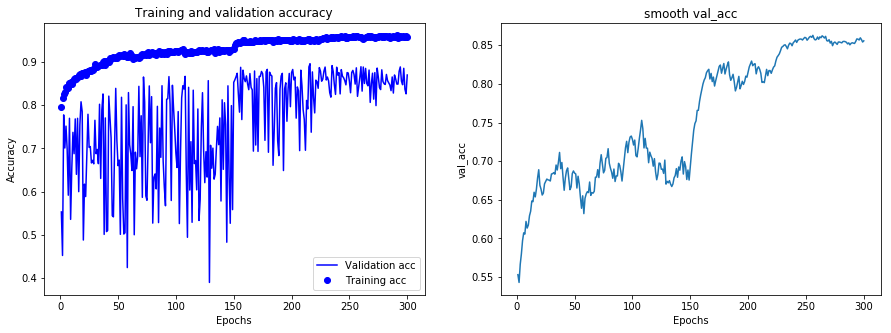

Highest val accuracy: x= 215, y= 0.8955173679060665


<Figure size 432x288 with 0 Axes>

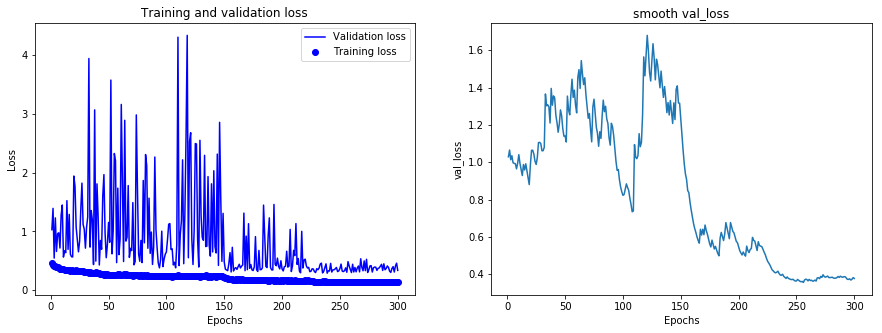

Lowest val loss: x= 238, y= 0.28949421295739436
29436.868528604507


In [8]:
plot_graphs(historyP4M_Altblocks6)
print(timeP4M_Altblocks6)

In [9]:
P4M_Altblocks6.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.4190806386347153, 0.853565313111546]

<Figure size 432x288 with 0 Axes>

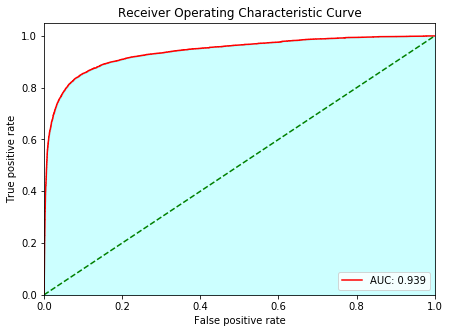

In [10]:
evaluate_auc(P4M_Altblocks6,test_generator)

In [11]:
P4M_Altblocks6.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_Altblocks6BestWeights239epochs.hdf5")

In [12]:
P4M_Altblocks6.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.37506747283697595, 0.8680283757338552]

<Figure size 432x288 with 0 Axes>

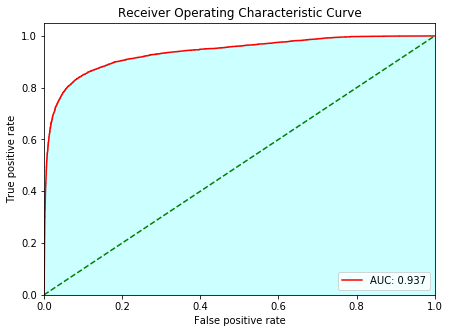

In [13]:
evaluate_auc(P4M_Altblocks6,test_generator)

#### Testing 4/1 so that I have a full array from 3-7 of dense block models with 1 LPB.

In [4]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_Altblocks7 = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=4,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=False)

In [7]:
P4M_Altblocks7.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 96, 96, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 96, 96, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [5]:
memory_required(P4M_Altblocks7,64)

3.493

In [6]:
%%notify

totalepochs=300

historyP4M_Altblocks7 = fit_model_to_directory_generator(P4M_Altblocks7,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_Altblocks7 = np.sum(time_check.epoch_times)
P4M_Altblocks7.save_weights("../model_saves/PCAM/PCam_Dense/P4M_Altblocks7Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 112s 360ms/step - loss: 0.4654 - acc: 0.8037 - val_loss: 1.6226 - val_acc: 0.5135
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 109s 348ms/step - loss: 0.4347 - acc: 0.8198 - val_loss: 0.7388 - val_acc: 0.7356
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 108s 347ms/step - loss: 0.4164 - acc: 0.8276 - val_loss: 1.2037 - val_acc: 0.5150
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 107s 343ms/step - loss: 0.4096 - acc: 0.8317 - val_loss: 0.8185 - val_acc: 0.7147
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 105s 337ms/step - loss: 0.2613 - acc: 0.9141 - val_loss: 0.8057 - val_acc: 0.7413
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.2603 - acc: 0.9152 - val_loss: 1.4619 - val_acc: 0.6156
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.2482 - acc: 0.9182 - val_loss: 1.2431 - val_acc: 0.6291
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.2521 - acc: 0.9174 - val_loss: 0.5688 - val_acc: 0.8383
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.2609 - acc: 0.9141 - val_loss: 2.2750 - val_acc: 0.

312/312 [==============================] - 105s 338ms/step - loss: 0.2221 - acc: 0.9304 - val_loss: 0.8620 - val_acc: 0.8257
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.2207 - acc: 0.9311 - val_loss: 1.3667 - val_acc: 0.6519
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.2190 - acc: 0.9322 - val_loss: 1.8062 - val_acc: 0.7447
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.2270 - acc: 0.9298 - val_loss: 0.6214 - val_acc: 0.7713
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 105s 337ms/step - loss: 0.2164 - acc: 0.9351 - val_loss: 0.4934 - val_acc

312/312 [==============================] - 105s 337ms/step - loss: 0.1639 - acc: 0.9518 - val_loss: 0.5123 - val_acc: 0.7980
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 105s 337ms/step - loss: 0.1576 - acc: 0.9525 - val_loss: 0.4048 - val_acc: 0.8648
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 105s 337ms/step - loss: 0.1578 - acc: 0.9544 - val_loss: 0.6507 - val_acc: 0.7663
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 105s 337ms/step - loss: 0.1546 - acc: 0.9549 - val_loss: 0.3144 - val_acc: 0.8809
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 105s 337ms/step - loss: 0.1582 - acc: 0.9555 - val_loss: 0.5326 - val

312/312 [==============================] - 105s 337ms/step - loss: 0.1497 - acc: 0.9544 - val_loss: 0.4719 - val_acc: 0.8513
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 105s 337ms/step - loss: 0.1465 - acc: 0.9560 - val_loss: 1.1564 - val_acc: 0.7038
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 105s 337ms/step - loss: 0.1476 - acc: 0.9559 - val_loss: 0.7387 - val_acc: 0.7510
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 105s 337ms/step - loss: 0.1432 - acc: 0.9564 - val_loss: 0.3832 - val_acc: 0.8571
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1367 - acc: 0.9610 - val_loss: 0.4877 - v

312/312 [==============================] - 105s 337ms/step - loss: 0.1262 - acc: 0.9648 - val_loss: 0.4678 - val_acc: 0.8304
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1295 - acc: 0.9638 - val_loss: 0.4097 - val_acc: 0.8493
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 338ms/step - loss: 0.1268 - acc: 0.9639 - val_loss: 0.4502 - val_acc: 0.8460
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1327 - acc: 0.9614 - val_loss: 0.3959 - val_acc: 0.8536
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1289 - acc: 0.9622 - val_loss: 0.4410 -

312/312 [==============================] - 105s 337ms/step - loss: 0.1296 - acc: 0.9628 - val_loss: 0.5120 - val_acc: 0.8203
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1189 - acc: 0.9665 - val_loss: 0.4377 - val_acc: 0.8445
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1239 - acc: 0.9633 - val_loss: 0.4314 - val_acc: 0.8402
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 105s 337ms/step - loss: 0.1232 - acc: 0.9659 - val_loss: 0.4384 - val_acc: 0.8368


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

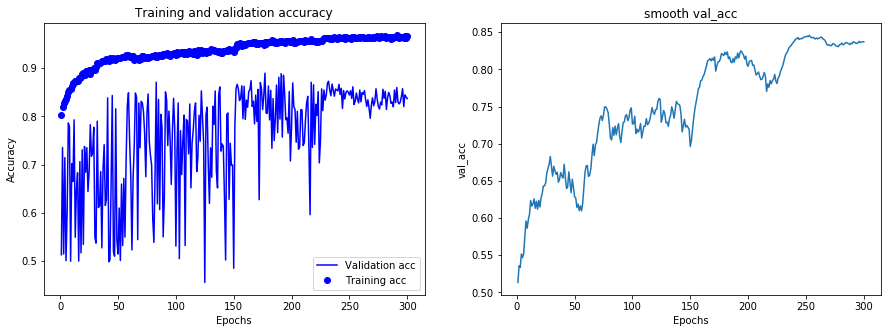

Highest val accuracy: x= 176, y= 0.8895853718199609


<Figure size 432x288 with 0 Axes>

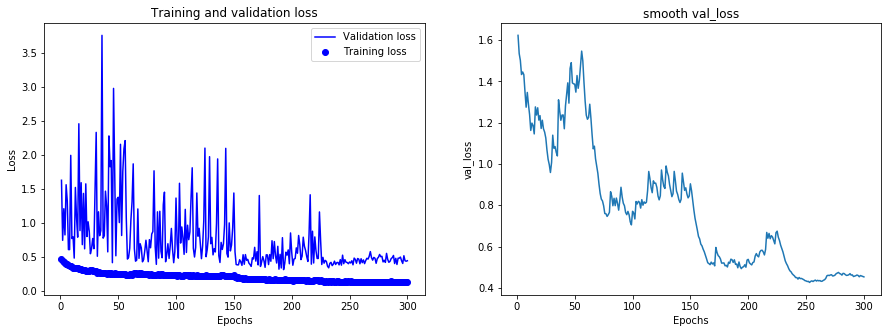

Lowest val loss: x= 192, y= 0.30745841408195795
31601.88530278206


In [7]:
plot_graphs(historyP4M_Altblocks7)
print(timeP4M_Altblocks7)

In [8]:
P4M_Altblocks7.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.540965280479181, 0.8407840019569471]

<Figure size 432x288 with 0 Axes>

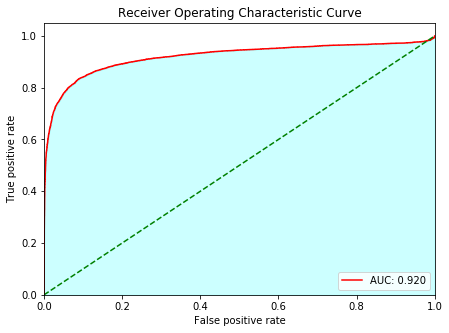

In [9]:
evaluate_auc(P4M_Altblocks7,test_generator)

In [10]:
P4M_Altblocks7.load_weights("../model_saves/PCAM/PCAM_Dense/P4M_Altblocks7BestWeights193epochs.hdf5")

In [11]:
P4M_Altblocks7.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3560407828619802, 0.8710249510763209]

<Figure size 432x288 with 0 Axes>

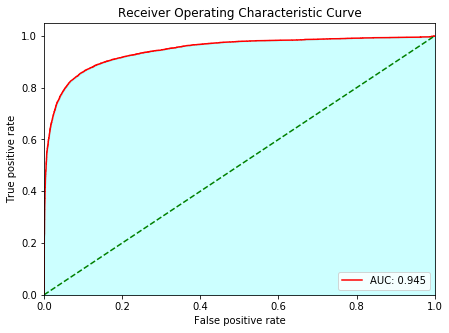

In [12]:
evaluate_auc(P4M_Altblocks7,test_generator)

# BC Model Testing<a class="anchor" id="bcmodels"></a>
----------------------------------

#### Running a BC variant

In [4]:
initial_filters = 2
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_BC = build_and_compile_dense_model(initial_filters,growth_rate=2,dense_blocks=2,conv_layers=4,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=True)

In [5]:
P4M_BC.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 96, 96, 16)   54          input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 96, 96, 16)   16          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 16)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [6]:
memory_required(P4M_BC,64)

4.035

In [7]:
%%notify

totalepochs=300

historyP4M_BC = fit_model_to_directory_generator(P4M_BC,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_BC = np.sum(time_check.epoch_times)
P4M_BC.save_weights("../model_saves/PCAM/PCam_Dense/P4M_BCFinal.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 122s 392ms/step - loss: 0.4979 - acc: 0.7709 - val_loss: 2.8661 - val_acc: 0.4683
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 117s 375ms/step - loss: 0.4666 - acc: 0.7950 - val_loss: 0.7645 - val_acc: 0.5890
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 117s 375ms/step - loss: 0.4468 - acc: 0.8090 - val_loss: 0.7581 - val_acc: 0.7546
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 117s 375ms/step - loss: 0.4328 - acc: 0.8109 - val_loss: 0.6391 - val_acc: 0.7627
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 116s 372ms/step - loss: 0.3061 - acc: 0.8850 - val_loss: 0.8019 - val_acc: 0.6366
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 116s 372ms/step - loss: 0.3053 - acc: 0.8865 - val_loss: 0.5316 - val_acc: 0.7796
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 116s 372ms/step - loss: 0.3073 - acc: 0.8865 - val_loss: 0.6627 - val_acc: 0.7059
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 116s 372ms/step - loss: 0.3008 - acc: 0.8892 - val_loss: 1.4190 - val_acc: 0.5141
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 116s 372ms/step - loss: 0.3042 - acc: 0.8878 - val_loss: 0.9647 - val_acc: 0.

312/312 [==============================] - 116s 373ms/step - loss: 0.2593 - acc: 0.9109 - val_loss: 0.4199 - val_acc: 0.8568
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 116s 373ms/step - loss: 0.2706 - acc: 0.9042 - val_loss: 0.7142 - val_acc: 0.7317
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 116s 372ms/step - loss: 0.2646 - acc: 0.9076 - val_loss: 0.4701 - val_acc: 0.8092
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 116s 372ms/step - loss: 0.2678 - acc: 0.9060 - val_loss: 0.5317 - val_acc: 0.7959
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 116s 372ms/step - loss: 0.2664 - acc: 0.9095 - val_loss: 1.0489 - val_acc

312/312 [==============================] - 116s 372ms/step - loss: 0.2155 - acc: 0.9274 - val_loss: 0.5636 - val_acc: 0.7999
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 116s 372ms/step - loss: 0.2124 - acc: 0.9287 - val_loss: 0.4704 - val_acc: 0.8314
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 116s 372ms/step - loss: 0.2091 - acc: 0.9302 - val_loss: 0.4148 - val_acc: 0.8483
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 116s 372ms/step - loss: 0.2159 - acc: 0.9274 - val_loss: 0.6945 - val_acc: 0.7525
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 116s 372ms/step - loss: 0.2086 - acc: 0.9298 - val_loss: 0.3602 - val

312/312 [==============================] - 116s 373ms/step - loss: 0.2051 - acc: 0.9295 - val_loss: 0.5501 - val_acc: 0.8086
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 116s 373ms/step - loss: 0.2029 - acc: 0.9307 - val_loss: 0.3986 - val_acc: 0.8573
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 116s 373ms/step - loss: 0.2042 - acc: 0.9296 - val_loss: 0.4007 - val_acc: 0.8576
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 116s 372ms/step - loss: 0.1992 - acc: 0.9326 - val_loss: 0.3952 - val_acc: 0.8441
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 116s 372ms/step - loss: 0.1931 - acc: 0.9333 - val_loss: 0.4326 - v

312/312 [==============================] - 118s 377ms/step - loss: 0.1895 - acc: 0.9363 - val_loss: 0.4060 - val_acc: 0.8478
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 121s 387ms/step - loss: 0.1904 - acc: 0.9361 - val_loss: 0.5030 - val_acc: 0.8101
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 121s 386ms/step - loss: 0.1886 - acc: 0.9361 - val_loss: 0.4347 - val_acc: 0.8339
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 120s 385ms/step - loss: 0.1896 - acc: 0.9367 - val_loss: 0.4410 - val_acc: 0.8312
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 120s 384ms/step - loss: 0.1962 - acc: 0.9347 - val_loss: 0.4269 -

312/312 [==============================] - 120s 386ms/step - loss: 0.1856 - acc: 0.9381 - val_loss: 0.4204 - val_acc: 0.8382
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 121s 387ms/step - loss: 0.1930 - acc: 0.9378 - val_loss: 0.4427 - val_acc: 0.8369
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 121s 386ms/step - loss: 0.1902 - acc: 0.9366 - val_loss: 0.4718 - val_acc: 0.8241
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 121s 386ms/step - loss: 0.1853 - acc: 0.9373 - val_loss: 0.4484 - val_acc: 0.8292


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

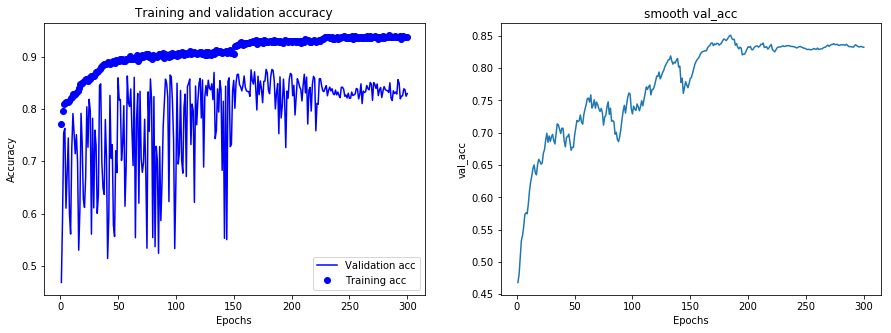

Highest val accuracy: x= 177, y= 0.8754280821917808


<Figure size 432x288 with 0 Axes>

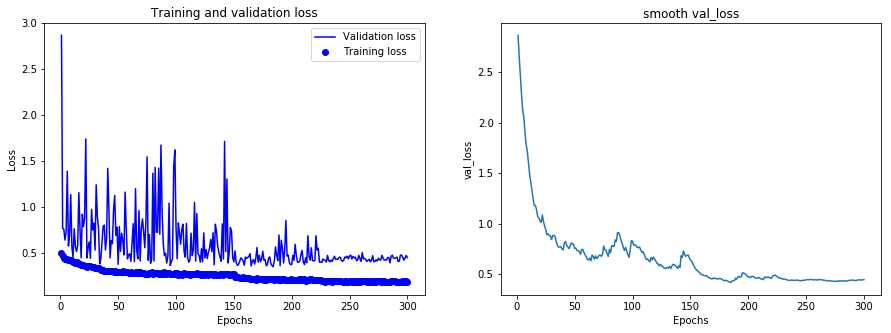

Lowest val loss: x= 183, y= 0.34901889671668146
35043.24292016029


In [8]:
plot_graphs(historyP4M_BC)
print(timeP4M_BC)

In [9]:
P4M_BC.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3673961127428393, 0.8636863992172211]

<Figure size 432x288 with 0 Axes>

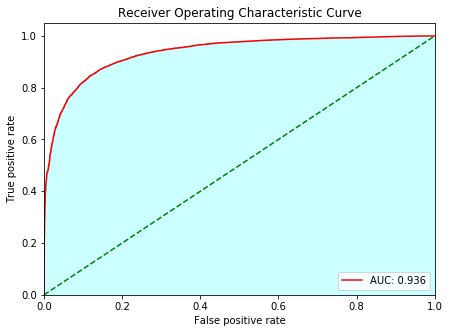

In [10]:
evaluate_auc(P4M_BC,test_generator)

In [11]:
P4M_BC.load_weights("../model_saves/PCAM/PCam_Dense/P4M_BCBestWeights184epochs.hdf5")

In [12]:
P4M_BC.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3519574785914906, 0.8767429060665362]

<Figure size 432x288 with 0 Axes>

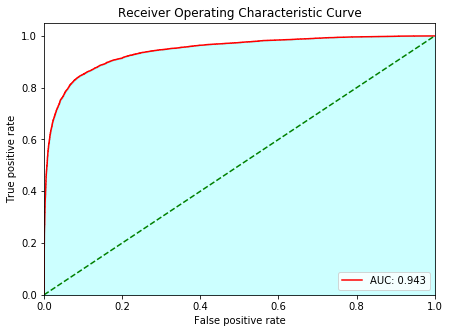

In [13]:
evaluate_auc(P4M_BC,test_generator)

#### Creating another variant, only small alterations due to memory constraints

In [4]:
initial_filters = 3
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_BC2 = build_and_compile_dense_model(initial_filters,growth_rate=3,dense_blocks=3,conv_layers=3,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=True)

In [32]:
P4M_BC2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_211 (GConv2D)          (None, 96, 96, 24)   81          input_9[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_211 (GBatchNorm)   (None, 96, 96, 24)   24          g_conv2d_211[0][0]               
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 96, 96, 24)   0           g_batch_norm_211[0][0]           
__________________________________________________________________________________________________
g_conv2d_2

In [33]:
memory_required(P4M_BC,64)

4.562

In [5]:
%%notify

totalepochs=300

historyP4M_BC2 = fit_model_to_directory_generator(P4M_BC2,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_BC2 = np.sum(time_check.epoch_times)
P4M_BC.save_weights("../model_saves/PCAM/PCam_Dense/P4M_BC2Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 150s 480ms/step - loss: 0.5741 - acc: 0.7150 - val_loss: 1.1745 - val_acc: 0.6048
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 144s 460ms/step - loss: 0.4692 - acc: 0.7965 - val_loss: 4.2904 - val_acc: 0.5335
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 144s 460ms/step - loss: 0.4530 - acc: 0.8089 - val_loss: 0.5601 - val_acc: 0.7365
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 144s 460ms/step - loss: 0.4395 - acc: 0.8181 - val_loss: 0.8891 - val_acc: 0.6800
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 139s 444ms/step - loss: 0.3213 - acc: 0.8781 - val_loss: 0.5497 - val_acc: 0.8071
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 139s 444ms/step - loss: 0.3083 - acc: 0.8850 - val_loss: 0.8525 - val_acc: 0.7996
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 139s 445ms/step - loss: 0.3022 - acc: 0.8859 - val_loss: 0.7811 - val_acc: 0.7614
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 139s 445ms/step - loss: 0.3118 - acc: 0.8805 - val_loss: 0.8120 - val_acc: 0.8065
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 139s 444ms/step - loss: 0.3130 - acc: 0.8839 - val_loss: 0.4541 - val_acc: 0.

312/312 [==============================] - 139s 444ms/step - loss: 0.2887 - acc: 0.8961 - val_loss: 0.5449 - val_acc: 0.7756
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 139s 444ms/step - loss: 0.2824 - acc: 0.9001 - val_loss: 0.6392 - val_acc: 0.8271
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 139s 444ms/step - loss: 0.2751 - acc: 0.9025 - val_loss: 0.9165 - val_acc: 0.5974
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 139s 444ms/step - loss: 0.2776 - acc: 0.9021 - val_loss: 0.5717 - val_acc: 0.7595
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 138s 444ms/step - loss: 0.2799 - acc: 0.9019 - val_loss: 0.3583 - val_acc

312/312 [==============================] - 139s 444ms/step - loss: 0.2098 - acc: 0.9288 - val_loss: 0.5765 - val_acc: 0.8534
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 138s 444ms/step - loss: 0.2070 - acc: 0.9311 - val_loss: 1.2881 - val_acc: 0.7820
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 138s 444ms/step - loss: 0.2086 - acc: 0.9306 - val_loss: 0.6231 - val_acc: 0.8457
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 138s 444ms/step - loss: 0.1998 - acc: 0.9335 - val_loss: 0.3994 - val_acc: 0.8573
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 138s 444ms/step - loss: 0.2065 - acc: 0.9307 - val_loss: 0.3258 - val

312/312 [==============================] - 138s 444ms/step - loss: 0.1986 - acc: 0.9330 - val_loss: 0.2990 - val_acc: 0.8881
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 139s 444ms/step - loss: 0.2049 - acc: 0.9312 - val_loss: 0.4888 - val_acc: 0.8446
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 138s 444ms/step - loss: 0.1948 - acc: 0.9336 - val_loss: 0.3696 - val_acc: 0.8802
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 139s 444ms/step - loss: 0.1999 - acc: 0.9336 - val_loss: 0.4023 - val_acc: 0.8737
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 138s 444ms/step - loss: 0.1940 - acc: 0.9344 - val_loss: 0.5977 - v

312/312 [==============================] - 142s 456ms/step - loss: 0.1781 - acc: 0.9412 - val_loss: 0.4767 - val_acc: 0.8529
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 142s 455ms/step - loss: 0.1803 - acc: 0.9418 - val_loss: 0.5022 - val_acc: 0.8426
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 457ms/step - loss: 0.1780 - acc: 0.9415 - val_loss: 0.5207 - val_acc: 0.8453
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 142s 455ms/step - loss: 0.1767 - acc: 0.9430 - val_loss: 0.6189 - val_acc: 0.8375
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 141s 453ms/step - loss: 0.1816 - acc: 0.9401 - val_loss: 0.4978 -

312/312 [==============================] - 140s 448ms/step - loss: 0.1900 - acc: 0.9368 - val_loss: 0.7494 - val_acc: 0.7791
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 139s 447ms/step - loss: 0.1770 - acc: 0.9417 - val_loss: 0.5318 - val_acc: 0.8323
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 140s 448ms/step - loss: 0.1774 - acc: 0.9414 - val_loss: 0.6305 - val_acc: 0.7941
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 140s 449ms/step - loss: 0.1751 - acc: 0.9407 - val_loss: 0.6450 - val_acc: 0.8073


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

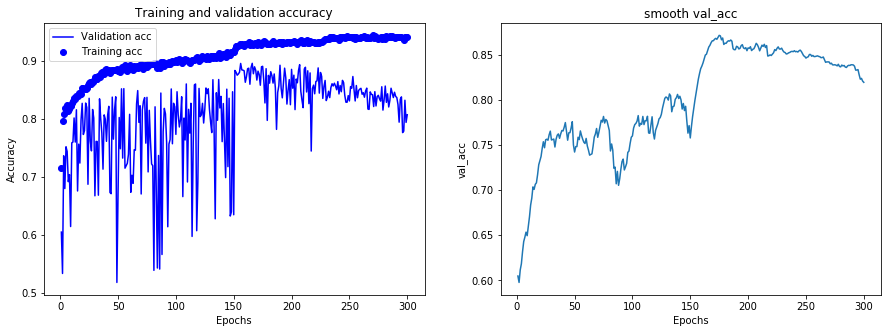

Highest val accuracy: x= 165, y= 0.8960066046966731


<Figure size 432x288 with 0 Axes>

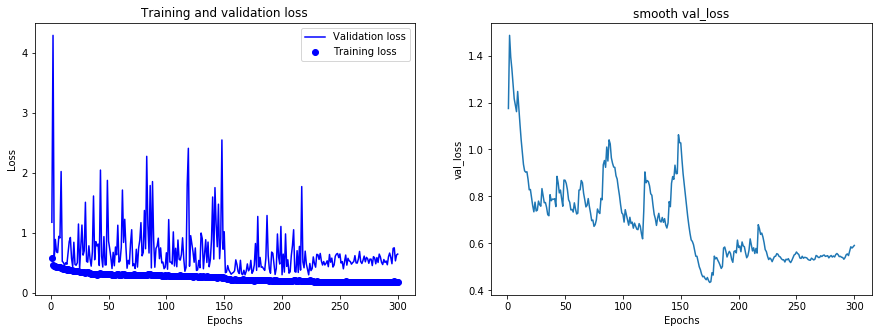

Lowest val loss: x= 222, y= 0.29896949015834795
41752.5586540699


In [6]:
plot_graphs(historyP4M_BC2)
print(timeP4M_BC2)

In [7]:
P4M_BC2.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.630357544628608, 0.8006360078277887]

<Figure size 432x288 with 0 Axes>

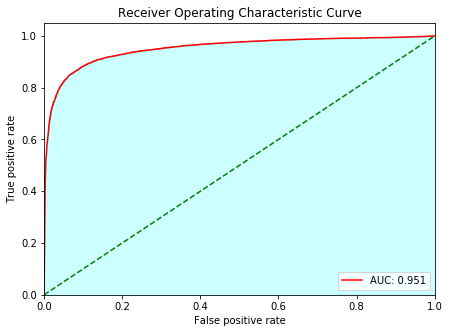

In [8]:
evaluate_auc(P4M_BC2,test_generator)

In [13]:
P4M_BC2.load_weights("../model_saves/PCAM/PCAM_DENSE/P4M_BC2BestWeights223epochs.hdf5")

In [14]:
P4M_BC2.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.3061486007445246, 0.8979635518590998]

<Figure size 432x288 with 0 Axes>

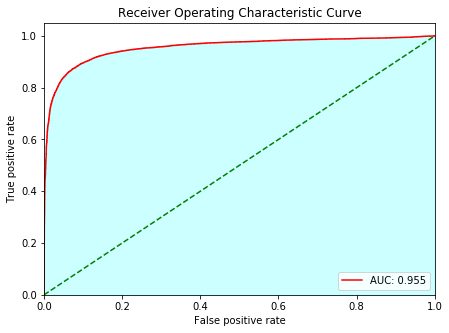

In [15]:
evaluate_auc(P4M_BC2,test_generator)

#### Model 3 - Increasing the dense blocks

In [12]:
initial_filters = 3
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_BC3 = build_and_compile_dense_model(initial_filters,growth_rate=3,dense_blocks=6,conv_layers=3,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=True)

In [13]:
memory_required(P4M_BC3,64)

4.706

In [15]:
P4M_BC3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_173 (GConv2D)          (None, 96, 96, 24)   81          input_5[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_173 (GBatchNorm)   (None, 96, 96, 24)   24          g_conv2d_173[0][0]               
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 96, 96, 24)   0           g_batch_norm_173[0][0]           
__________________________________________________________________________________________________
g_conv2d_1

In [16]:
%%notify

totalepochs=300

historyP4M_BC3 = fit_model_to_directory_generator(P4M_BC3,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_BC3 = np.sum(time_check.epoch_times)
P4M_BC3.save_weights("../model_saves/PCAM/PCam_Dense/P4M_BC3Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 164s 525ms/step - loss: 0.6102 - acc: 0.7392 - val_loss: 0.6736 - val_acc: 0.7026
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 470ms/step - loss: 0.5459 - acc: 0.7876 - val_loss: 2.4870 - val_acc: 0.5007
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 467ms/step - loss: 0.5287 - acc: 0.7951 - val_loss: 0.7389 - val_acc: 0.6520
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 471ms/step - loss: 0.5144 - acc: 0.7977 - val_loss: 0.5418 - val_acc: 0.8084
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 145s 465ms/step - loss: 0.2412 - acc: 0.9207 - val_loss: 0.5332 - val_acc: 0.8194
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 465ms/step - loss: 0.2370 - acc: 0.9242 - val_loss: 1.7437 - val_acc: 0.5519
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 465ms/step - loss: 0.2489 - acc: 0.9165 - val_loss: 0.4065 - val_acc: 0.8629
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 465ms/step - loss: 0.2391 - acc: 0.9226 - val_loss: 0.4610 - val_acc: 0.8103
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 465ms/step - loss: 0.2384 - acc: 0.9233 - val_loss: 0.5442 - val_acc: 0.

312/312 [==============================] - 149s 478ms/step - loss: 0.2193 - acc: 0.9323 - val_loss: 0.5398 - val_acc: 0.7999
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 472ms/step - loss: 0.2242 - acc: 0.9319 - val_loss: 0.5444 - val_acc: 0.7995
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 149s 477ms/step - loss: 0.2185 - acc: 0.9320 - val_loss: 0.4304 - val_acc: 0.8652
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 472ms/step - loss: 0.2190 - acc: 0.9323 - val_loss: 0.4728 - val_acc: 0.8553
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 150s 479ms/step - loss: 0.2185 - acc: 0.9326 - val_loss: 0.3791 - val_acc

312/312 [==============================] - 151s 484ms/step - loss: 0.1553 - acc: 0.9531 - val_loss: 0.4232 - val_acc: 0.8596
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 151s 485ms/step - loss: 0.1593 - acc: 0.9534 - val_loss: 0.3878 - val_acc: 0.8697
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 151s 484ms/step - loss: 0.1561 - acc: 0.9521 - val_loss: 0.6360 - val_acc: 0.8074
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 151s 484ms/step - loss: 0.1601 - acc: 0.9517 - val_loss: 0.3174 - val_acc: 0.8964
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 151s 484ms/step - loss: 0.1564 - acc: 0.9538 - val_loss: 0.5460 - val

312/312 [==============================] - 152s 487ms/step - loss: 0.1522 - acc: 0.9531 - val_loss: 0.6283 - val_acc: 0.7920
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 152s 486ms/step - loss: 0.1425 - acc: 0.9566 - val_loss: 0.2705 - val_acc: 0.9088
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 152s 486ms/step - loss: 0.1477 - acc: 0.9552 - val_loss: 0.3215 - val_acc: 0.8938
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 151s 483ms/step - loss: 0.1457 - acc: 0.9561 - val_loss: 0.3397 - val_acc: 0.8872
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 151s 485ms/step - loss: 0.1414 - acc: 0.9580 - val_loss: 0.3199 - v

312/312 [==============================] - 151s 484ms/step - loss: 0.1291 - acc: 0.9629 - val_loss: 0.3290 - val_acc: 0.8880
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 151s 484ms/step - loss: 0.1336 - acc: 0.9597 - val_loss: 0.3352 - val_acc: 0.8887
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 151s 484ms/step - loss: 0.1371 - acc: 0.9569 - val_loss: 0.3337 - val_acc: 0.8872
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 151s 485ms/step - loss: 0.1337 - acc: 0.9602 - val_loss: 0.3512 - val_acc: 0.8811
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 151s 485ms/step - loss: 0.1299 - acc: 0.9608 - val_loss: 0.3879 -

312/312 [==============================] - 151s 483ms/step - loss: 0.1316 - acc: 0.9610 - val_loss: 0.3560 - val_acc: 0.8839
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 151s 483ms/step - loss: 0.1310 - acc: 0.9602 - val_loss: 0.3587 - val_acc: 0.8778
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 151s 483ms/step - loss: 0.1314 - acc: 0.9618 - val_loss: 0.4109 - val_acc: 0.8616
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 151s 484ms/step - loss: 0.1330 - acc: 0.9608 - val_loss: 0.3356 - val_acc: 0.8844


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

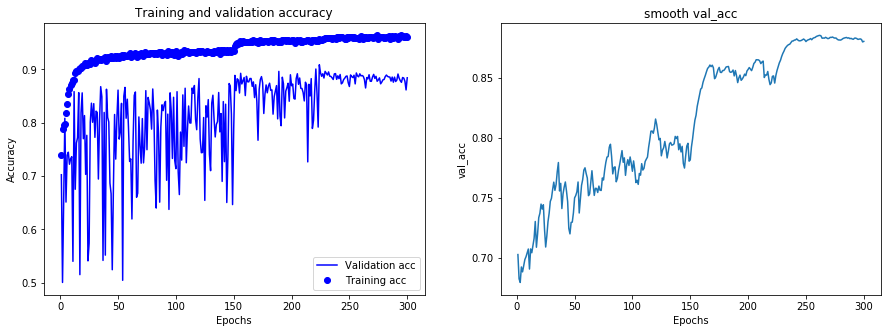

Highest val accuracy: x= 223, y= 0.908818493150685


<Figure size 432x288 with 0 Axes>

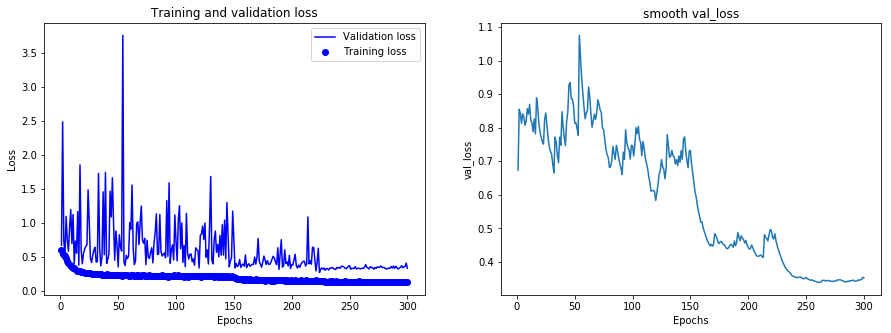

Lowest val loss: x= 223, y= 0.2704549527885629
44702.64112615585


In [17]:
plot_graphs(historyP4M_BC3)
print(timeP4M_BC3)

In [18]:
P4M_BC3.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.29414301193565306, 0.8992477984344422]

<Figure size 432x288 with 0 Axes>

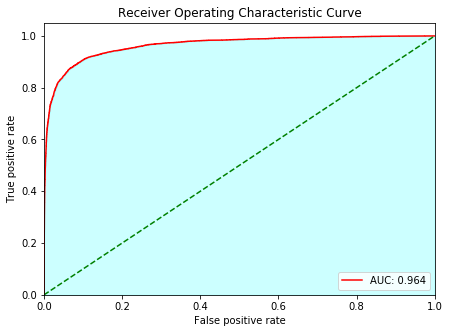

In [19]:
evaluate_auc(P4M_BC3,test_generator)

In [20]:
P4M_BC3.load_weights("../model_saves/PCAM/PCam_Dense/P4M_BC3BestWeights224epochs.hdf5")

In [21]:
P4M_BC3.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.2565299511947277, 0.9108060176125244]

<Figure size 432x288 with 0 Axes>

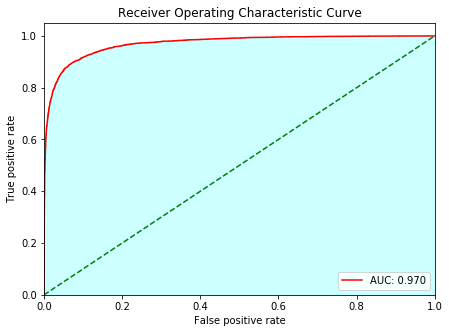

In [22]:
evaluate_auc(P4M_BC3,test_generator)

#### Testing BC models with the X/1 structure. First 5/1

In [15]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_BC4 = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=5,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=True)

In [16]:
P4M_BC4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_67 (GConv2D)           (None, 96, 96, 96)   324         input_5[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_67 (GBatchNorm)    (None, 96, 96, 96)   96          g_conv2d_67[0][0]                
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 96, 96, 96)   0           g_batch_norm_67[0][0]            
__________________________________________________________________________________________________
g_conv2d_6

In [17]:
memory_required(P4M_BC4,64)

4.365

In [18]:
%%notify

totalepochs=300

historyP4M_BC4 = fit_model_to_directory_generator(P4M_BC4,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_BC4 = np.sum(time_check.epoch_times)
P4M_BC4.save_weights("../model_saves/PCAM/PCam_Dense/P4M_BC4Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 152s 486ms/step - loss: 0.5119 - acc: 0.7843 - val_loss: 1.1406 - val_acc: 0.5467
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 144s 462ms/step - loss: 0.4520 - acc: 0.8175 - val_loss: 0.5825 - val_acc: 0.7321
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 144s 461ms/step - loss: 0.4338 - acc: 0.8260 - val_loss: 1.0556 - val_acc: 0.5347
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 144s 461ms/step - loss: 0.4109 - acc: 0.8385 - val_loss: 0.7523 - val_acc: 0.6265
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 145s 465ms/step - loss: 0.2720 - acc: 0.9071 - val_loss: 0.4820 - val_acc: 0.8356
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 465ms/step - loss: 0.2611 - acc: 0.9099 - val_loss: 0.9782 - val_acc: 0.6208
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 463ms/step - loss: 0.2697 - acc: 0.9097 - val_loss: 0.4886 - val_acc: 0.8068
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 144s 463ms/step - loss: 0.2563 - acc: 0.9128 - val_loss: 0.8665 - val_acc: 0.6907
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 464ms/step - loss: 0.2641 - acc: 0.9116 - val_loss: 0.8466 - val_acc: 0.

312/312 [==============================] - 146s 466ms/step - loss: 0.2280 - acc: 0.9272 - val_loss: 1.3335 - val_acc: 0.7051
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 466ms/step - loss: 0.2260 - acc: 0.9293 - val_loss: 0.9531 - val_acc: 0.6918
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 469ms/step - loss: 0.2196 - acc: 0.9298 - val_loss: 0.4782 - val_acc: 0.8062
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 470ms/step - loss: 0.2248 - acc: 0.9287 - val_loss: 0.3564 - val_acc: 0.8736
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 147s 470ms/step - loss: 0.2262 - acc: 0.9282 - val_loss: 0.3773 - val_acc

312/312 [==============================] - 143s 457ms/step - loss: 0.1694 - acc: 0.9481 - val_loss: 0.4227 - val_acc: 0.8480
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 457ms/step - loss: 0.1660 - acc: 0.9502 - val_loss: 0.4283 - val_acc: 0.8402
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 457ms/step - loss: 0.1617 - acc: 0.9506 - val_loss: 0.3469 - val_acc: 0.8833
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 457ms/step - loss: 0.1596 - acc: 0.9535 - val_loss: 0.3950 - val_acc: 0.8725
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 457ms/step - loss: 0.1591 - acc: 0.9522 - val_loss: 0.9323 - val

312/312 [==============================] - 143s 457ms/step - loss: 0.1496 - acc: 0.9536 - val_loss: 0.4700 - val_acc: 0.8429
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 457ms/step - loss: 0.1523 - acc: 0.9531 - val_loss: 1.3770 - val_acc: 0.7744
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 457ms/step - loss: 0.1487 - acc: 0.9543 - val_loss: 0.4874 - val_acc: 0.8343
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 143s 457ms/step - loss: 0.1507 - acc: 0.9550 - val_loss: 0.3613 - val_acc: 0.8597
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 457ms/step - loss: 0.1476 - acc: 0.9544 - val_loss: 0.3410 - v

312/312 [==============================] - 143s 457ms/step - loss: 0.1380 - acc: 0.9586 - val_loss: 0.3597 - val_acc: 0.8666
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 457ms/step - loss: 0.1350 - acc: 0.9590 - val_loss: 0.3792 - val_acc: 0.8603
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 457ms/step - loss: 0.1358 - acc: 0.9594 - val_loss: 0.3899 - val_acc: 0.8560
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 457ms/step - loss: 0.1380 - acc: 0.9577 - val_loss: 0.3905 - val_acc: 0.8555
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 457ms/step - loss: 0.1362 - acc: 0.9604 - val_loss: 0.3757 -

312/312 [==============================] - 143s 457ms/step - loss: 0.1415 - acc: 0.9558 - val_loss: 0.3696 - val_acc: 0.8663
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 457ms/step - loss: 0.1334 - acc: 0.9616 - val_loss: 0.3701 - val_acc: 0.8643
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 457ms/step - loss: 0.1315 - acc: 0.9610 - val_loss: 0.3488 - val_acc: 0.8761
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 457ms/step - loss: 0.1327 - acc: 0.9611 - val_loss: 0.3724 - val_acc: 0.8632


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

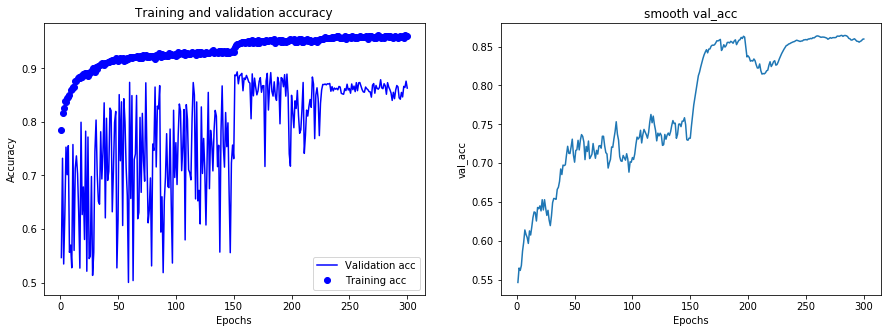

Highest val accuracy: x= 152, y= 0.8934686888454012


<Figure size 432x288 with 0 Axes>

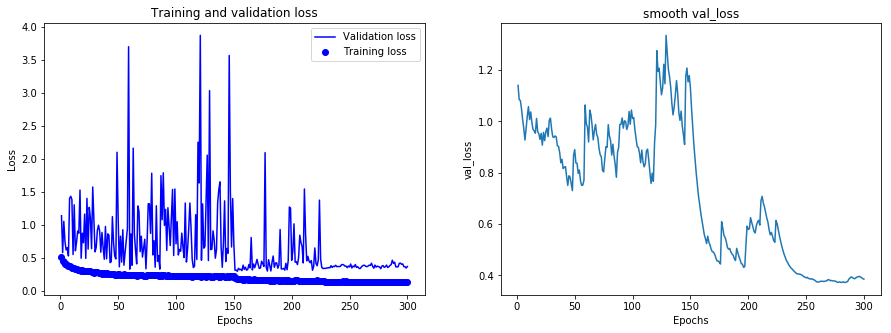

Lowest val loss: x= 152, y= 0.29927385888570907
43109.74697637558


In [19]:
plot_graphs(historyP4M_BC4)
print(timeP4M_BC4)

In [20]:
P4M_BC4.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.5918885745006065, 0.812866927592955]

<Figure size 432x288 with 0 Axes>

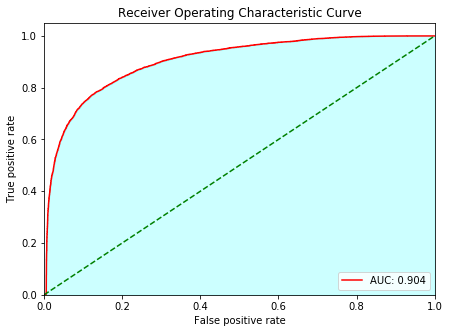

In [21]:
evaluate_auc(P4M_BC4,test_generator)

In [25]:
P4M_BC4.load_weights("../model_saves/PCAM/PCam_Dense/P4M_BC4BestWeights153epochs.hdf5")

In [26]:
P4M_BC4.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.42759350612905395, 0.8473275440313112]

<Figure size 432x288 with 0 Axes>

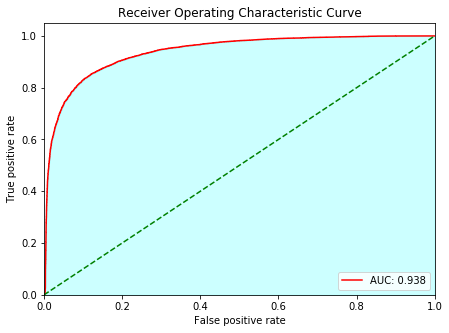

In [27]:
evaluate_auc(P4M_BC4,test_generator)

#### Model bc 6/1

In [4]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_BC5 = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=6,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=True)

In [5]:
P4M_BC5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
g_conv2d_1 (GConv2D)            (None, 96, 96, 96)   324         input_1[0][0]                    
__________________________________________________________________________________________________
g_batch_norm_1 (GBatchNorm)     (None, 96, 96, 96)   96          g_conv2d_1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 96)   0           g_batch_norm_1[0][0]             
__________________________________________________________________________________________________
g_conv2d_2

In [6]:
memory_required(P4M_BC5,64)

4.371

In [10]:
%%notify

totalepochs=300

historyP4M_BC5 = fit_model_to_directory_generator(P4M_BC5,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_BC5 = np.sum(time_check.epoch_times)
P4M_BC5.save_weights("../model_saves/PCAM/PCam_Dense/P4M_BC5Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 150s 482ms/step - loss: 0.5101 - acc: 0.7957 - val_loss: 0.6133 - val_acc: 0.7281
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 464ms/step - loss: 0.4712 - acc: 0.8147 - val_loss: 0.6852 - val_acc: 0.6525
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 464ms/step - loss: 0.4636 - acc: 0.8198 - val_loss: 1.0535 - val_acc: 0.5785
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 464ms/step - loss: 0.4530 - acc: 0.8212 - val_loss: 1.0273 - val_acc: 0.6068
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 145s 466ms/step - loss: 0.2518 - acc: 0.9148 - val_loss: 0.7212 - val_acc: 0.6823
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 468ms/step - loss: 0.2521 - acc: 0.9139 - val_loss: 0.5334 - val_acc: 0.7683
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 465ms/step - loss: 0.2472 - acc: 0.9178 - val_loss: 0.6498 - val_acc: 0.7358
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 467ms/step - loss: 0.2458 - acc: 0.9155 - val_loss: 1.1984 - val_acc: 0.5513
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 146s 467ms/step - loss: 0.2446 - acc: 0.9165 - val_loss: 1.1123 - val_acc: 0.

312/312 [==============================] - 149s 477ms/step - loss: 0.2270 - acc: 0.9279 - val_loss: 1.1241 - val_acc: 0.6392
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 148s 474ms/step - loss: 0.2309 - acc: 0.9249 - val_loss: 0.5597 - val_acc: 0.8244
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 145s 466ms/step - loss: 0.2241 - acc: 0.9283 - val_loss: 1.0168 - val_acc: 0.6819
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 144s 462ms/step - loss: 0.2270 - acc: 0.9273 - val_loss: 0.6658 - val_acc: 0.7035
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 144s 462ms/step - loss: 0.2329 - acc: 0.9232 - val_loss: 0.4265 - val_acc

312/312 [==============================] - 143s 459ms/step - loss: 0.1608 - acc: 0.9511 - val_loss: 0.5735 - val_acc: 0.7993
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 459ms/step - loss: 0.1567 - acc: 0.9547 - val_loss: 0.6511 - val_acc: 0.7911
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 459ms/step - loss: 0.1635 - acc: 0.9520 - val_loss: 0.3272 - val_acc: 0.8878
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 459ms/step - loss: 0.1601 - acc: 0.9521 - val_loss: 0.7299 - val_acc: 0.7571
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 459ms/step - loss: 0.1575 - acc: 0.9539 - val_loss: 0.3403 - val

312/312 [==============================] - 143s 459ms/step - loss: 0.1503 - acc: 0.9534 - val_loss: 0.4703 - val_acc: 0.8414
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 459ms/step - loss: 0.1542 - acc: 0.9522 - val_loss: 0.5567 - val_acc: 0.8465
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 143s 459ms/step - loss: 0.1537 - acc: 0.9521 - val_loss: 0.4320 - val_acc: 0.8475
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 143s 459ms/step - loss: 0.1483 - acc: 0.9551 - val_loss: 0.3274 - val_acc: 0.8940
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 459ms/step - loss: 0.1400 - acc: 0.9579 - val_loss: 0.3561 - v

312/312 [==============================] - 143s 459ms/step - loss: 0.1377 - acc: 0.9581 - val_loss: 0.3163 - val_acc: 0.9031
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 459ms/step - loss: 0.1318 - acc: 0.9624 - val_loss: 0.3277 - val_acc: 0.8968
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 459ms/step - loss: 0.1406 - acc: 0.9596 - val_loss: 0.3776 - val_acc: 0.8811
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 459ms/step - loss: 0.1396 - acc: 0.9571 - val_loss: 0.3456 - val_acc: 0.8878
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 143s 460ms/step - loss: 0.1368 - acc: 0.9591 - val_loss: 0.3559 -

312/312 [==============================] - 147s 472ms/step - loss: 0.1326 - acc: 0.9606 - val_loss: 0.3564 - val_acc: 0.8868
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 147s 472ms/step - loss: 0.1337 - acc: 0.9597 - val_loss: 0.3705 - val_acc: 0.8820
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 147s 472ms/step - loss: 0.1343 - acc: 0.9605 - val_loss: 0.4174 - val_acc: 0.8620
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 147s 473ms/step - loss: 0.1325 - acc: 0.9619 - val_loss: 0.3284 - val_acc: 0.8940


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

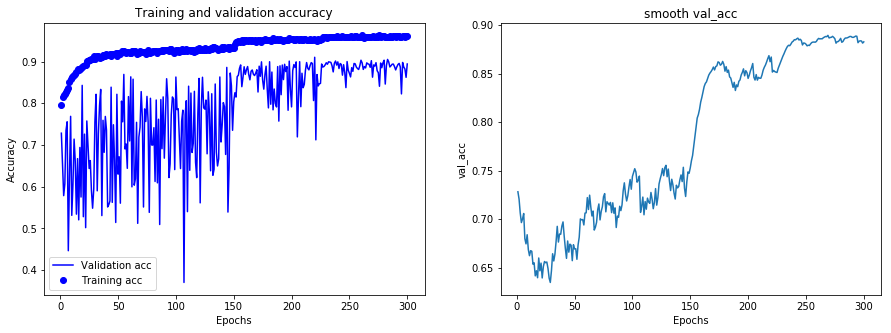

Highest val accuracy: x= 219, y= 0.9101638943248532


<Figure size 432x288 with 0 Axes>

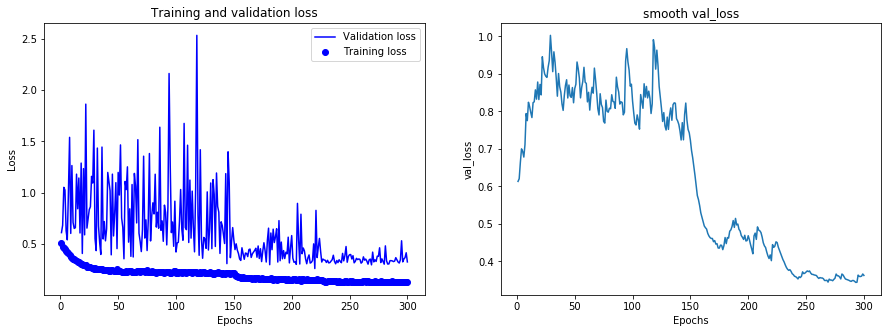

Lowest val loss: x= 219, y= 0.2640418027128492
43384.32088160515


In [11]:
plot_graphs(historyP4M_BC5)
print(timeP4M_BC5)

In [12]:
P4M_BC5.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.35777151467982105, 0.88989114481409]

<Figure size 432x288 with 0 Axes>

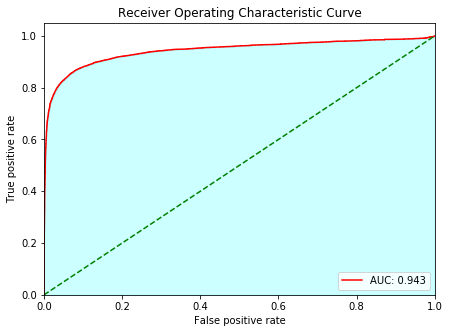

In [13]:
evaluate_auc(P4M_BC5,test_generator)

In [14]:
P4M_BC5.load_weights("../model_saves/PCAM/PCam_Dense/P4M_BC5BestWeights220epochs.hdf5")

In [15]:
P4M_BC5.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.2800861507537547, 0.9053938356164384]

<Figure size 432x288 with 0 Axes>

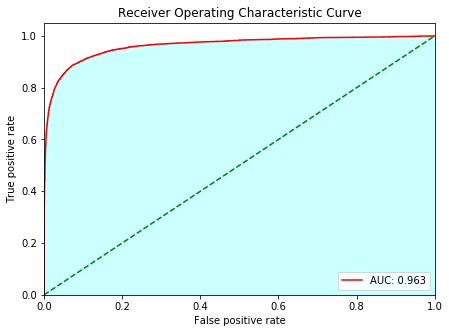

In [16]:
evaluate_auc(P4M_BC5,test_generator)

#### Model bc 7/1

In [4]:
initial_filters = 12
weight_decay = 1e-4 # Setting from the DenseNet paper
P4M_BC6 = build_and_compile_dense_model(initial_filters,growth_rate=8,dense_blocks=7,conv_layers=1,
                                           is_gconv=True,gconv_type="D4",padding="same",dropout=0.2,img_size=96,
                                           opt="DenseSGD",weight_decay=weight_decay,output="sigmoid",labels=1,bc_model=True)

In [ ]:
P4M_BC6.summary()

In [6]:
memory_required(P4M_BC6,64)

4.372

In [7]:
%%notify

totalepochs=300

historyP4M_BC6 = fit_model_to_directory_generator(P4M_BC6,train_datagen,tr_dir,validation_generator,
                                           callbacks=callbacks,steps=312,val_steps=len(validation_generator)-1,batch_size=64,epochs=totalepochs,verbose=1)
timeP4M_BC6 = np.sum(time_check.epoch_times)
P4M_BC6.save_weights("../model_saves/PCAM/PCam_Dense/P4M_BC6Final.h5")

Found 262144 images belonging to 2 classes.
Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 158s 506ms/step - loss: 0.5400 - acc: 0.7887 - val_loss: 1.8102 - val_acc: 0.5199
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 152s 487ms/step - loss: 0.4726 - acc: 0.8287 - val_loss: 1.1150 - val_acc: 0.5985
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 153s 489ms/step - loss: 0.4531 - acc: 0.8301 - val_loss: 0.6545 - val_acc: 0.7207
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 153s 491ms/step - loss: 0.4270 - acc: 0.8412 - val_loss: 0.6267 - val_acc: 0.7661
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 0.10000

312/312 [==============================] - 153s 491ms/step - loss: 0.3029 - acc: 0.8923 - val_loss: 0.8262 - val_acc: 0.6995
Epoch 39/300

Epoch 00039: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 153s 491ms/step - loss: 0.3027 - acc: 0.8903 - val_loss: 2.4706 - val_acc: 0.5015
Epoch 40/300

Epoch 00040: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 151s 485ms/step - loss: 0.2989 - acc: 0.8917 - val_loss: 1.0166 - val_acc: 0.6158
Epoch 41/300

Epoch 00041: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 151s 484ms/step - loss: 0.2924 - acc: 0.8952 - val_loss: 1.0544 - val_acc: 0.7241
Epoch 42/300

Epoch 00042: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 151s 484ms/step - loss: 0.3022 - acc: 0.8898 - val_loss: 1.0180 - val_acc: 0.

312/312 [==============================] - 150s 481ms/step - loss: 0.2447 - acc: 0.9211 - val_loss: 0.4329 - val_acc: 0.8344
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 150s 480ms/step - loss: 0.2389 - acc: 0.9226 - val_loss: 1.6566 - val_acc: 0.5804
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 150s 481ms/step - loss: 0.2453 - acc: 0.9201 - val_loss: 0.7062 - val_acc: 0.7959
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 150s 481ms/step - loss: 0.2375 - acc: 0.9238 - val_loss: 1.6721 - val_acc: 0.5570
Epoch 116/300

Epoch 00116: LearningRateScheduler setting learning rate to 0.10000000149011612.
312/312 [==============================] - 150s 481ms/step - loss: 0.2427 - acc: 0.9246 - val_loss: 0.6131 - val_acc

312/312 [==============================] - 150s 481ms/step - loss: 0.1654 - acc: 0.9506 - val_loss: 0.4315 - val_acc: 0.8507
Epoch 187/300

Epoch 00187: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 150s 480ms/step - loss: 0.1671 - acc: 0.9504 - val_loss: 0.3424 - val_acc: 0.8773
Epoch 188/300

Epoch 00188: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 150s 480ms/step - loss: 0.1718 - acc: 0.9474 - val_loss: 0.4755 - val_acc: 0.8376
Epoch 189/300

Epoch 00189: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 150s 481ms/step - loss: 0.1693 - acc: 0.9481 - val_loss: 0.4310 - val_acc: 0.8479
Epoch 190/300

Epoch 00190: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 150s 480ms/step - loss: 0.1574 - acc: 0.9517 - val_loss: 0.3537 - val

312/312 [==============================] - 150s 480ms/step - loss: 0.1593 - acc: 0.9506 - val_loss: 0.3697 - val_acc: 0.8685
Epoch 224/300

Epoch 00224: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 150s 480ms/step - loss: 0.1634 - acc: 0.9494 - val_loss: 0.4205 - val_acc: 0.8395
Epoch 225/300

Epoch 00225: LearningRateScheduler setting learning rate to 0.009999999776482582.
312/312 [==============================] - 150s 481ms/step - loss: 0.1605 - acc: 0.9495 - val_loss: 0.3707 - val_acc: 0.8675
Epoch 226/300

Epoch 00226: LearningRateScheduler setting learning rate to 0.0009999999776482583.
312/312 [==============================] - 150s 480ms/step - loss: 0.1463 - acc: 0.9558 - val_loss: 0.3406 - val_acc: 0.8837
Epoch 227/300

Epoch 00227: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 150s 480ms/step - loss: 0.1495 - acc: 0.9554 - val_loss: 0.2866 - v

312/312 [==============================] - 151s 484ms/step - loss: 0.1407 - acc: 0.9575 - val_loss: 0.2964 - val_acc: 0.8964
Epoch 261/300

Epoch 00261: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 152s 487ms/step - loss: 0.1441 - acc: 0.9558 - val_loss: 0.2991 - val_acc: 0.8936
Epoch 262/300

Epoch 00262: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 152s 487ms/step - loss: 0.1318 - acc: 0.9611 - val_loss: 0.3064 - val_acc: 0.8963
Epoch 263/300

Epoch 00263: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 152s 487ms/step - loss: 0.1369 - acc: 0.9597 - val_loss: 0.3049 - val_acc: 0.8967
Epoch 264/300

Epoch 00264: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 152s 487ms/step - loss: 0.1380 - acc: 0.9579 - val_loss: 0.3041 -

312/312 [==============================] - 152s 488ms/step - loss: 0.1436 - acc: 0.9563 - val_loss: 0.3382 - val_acc: 0.8886
Epoch 298/300

Epoch 00298: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 152s 488ms/step - loss: 0.1338 - acc: 0.9595 - val_loss: 0.2905 - val_acc: 0.8992
Epoch 299/300

Epoch 00299: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 153s 490ms/step - loss: 0.1357 - acc: 0.9593 - val_loss: 0.3094 - val_acc: 0.8912
Epoch 300/300

Epoch 00300: LearningRateScheduler setting learning rate to 0.0009999999310821295.
312/312 [==============================] - 154s 493ms/step - loss: 0.1398 - acc: 0.9574 - val_loss: 0.3096 - val_acc: 0.8939


<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

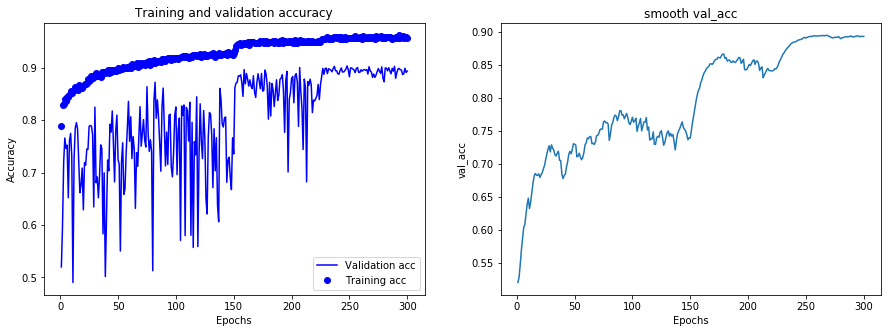

Highest val accuracy: x= 247, y= 0.9038955479452054


<Figure size 432x288 with 0 Axes>

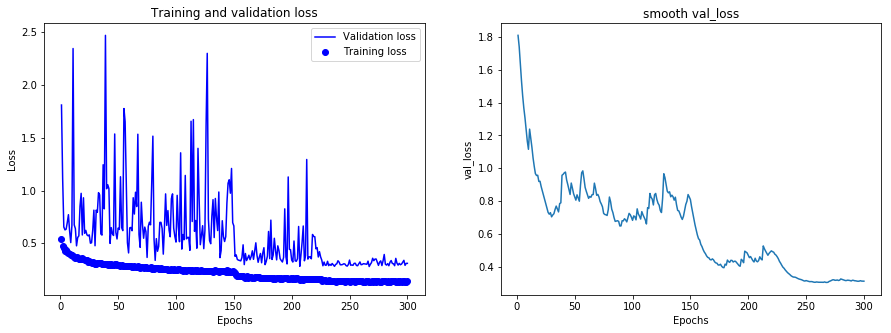

Lowest val loss: x= 266, y= 0.2792518904647715
45284.72673916817


In [8]:
plot_graphs(historyP4M_BC6)
print(timeP4M_BC6)

In [9]:
P4M_BC6.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.37349811850986836, 0.8705662915851272]

<Figure size 432x288 with 0 Axes>

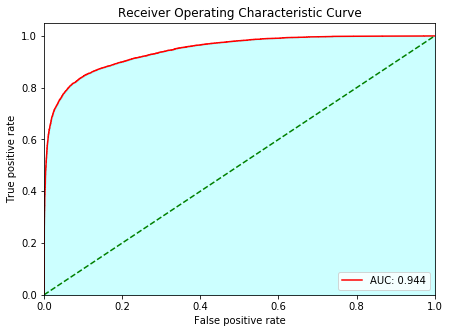

In [10]:
evaluate_auc(P4M_BC6,test_generator)

In [11]:
P4M_BC6.load_weights("../model_saves/PCAM/PCam_Dense/P4M_BC6BestWeights267epochs.hdf5")

In [12]:
P4M_BC6.evaluate_generator(test_generator,steps=len(test_generator)-1)

[0.35549776250252285, 0.8764982876712328]

<Figure size 432x288 with 0 Axes>

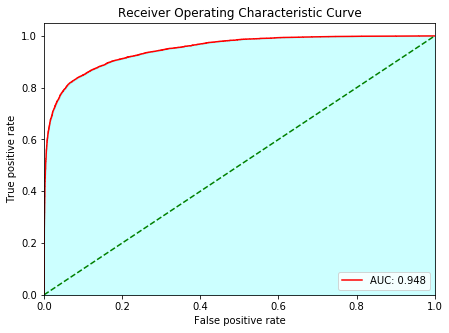

In [13]:
evaluate_auc(P4M_BC6,test_generator)